# Viajes en STM - Procesamiento de datos

In [25]:
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
from numpy import str_
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

sns.set_context("paper")
# sns.set() 
plt.style.use("seaborn-dark")


## Fecha de inicio de la pandemia

Declaración de estado de emergencia sanitaria fue el 13/03/2020: https://www.impo.com.uy/bases/decretos/93-2020.

Se busca una baja drástica en el uso del transporte público en una fecha próxima al 13/03.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 962 entries, 2019-11-01 to 2022-06-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   trips   962 non-null    int64
dtypes: int64(1)
memory usage: 15.0 KB


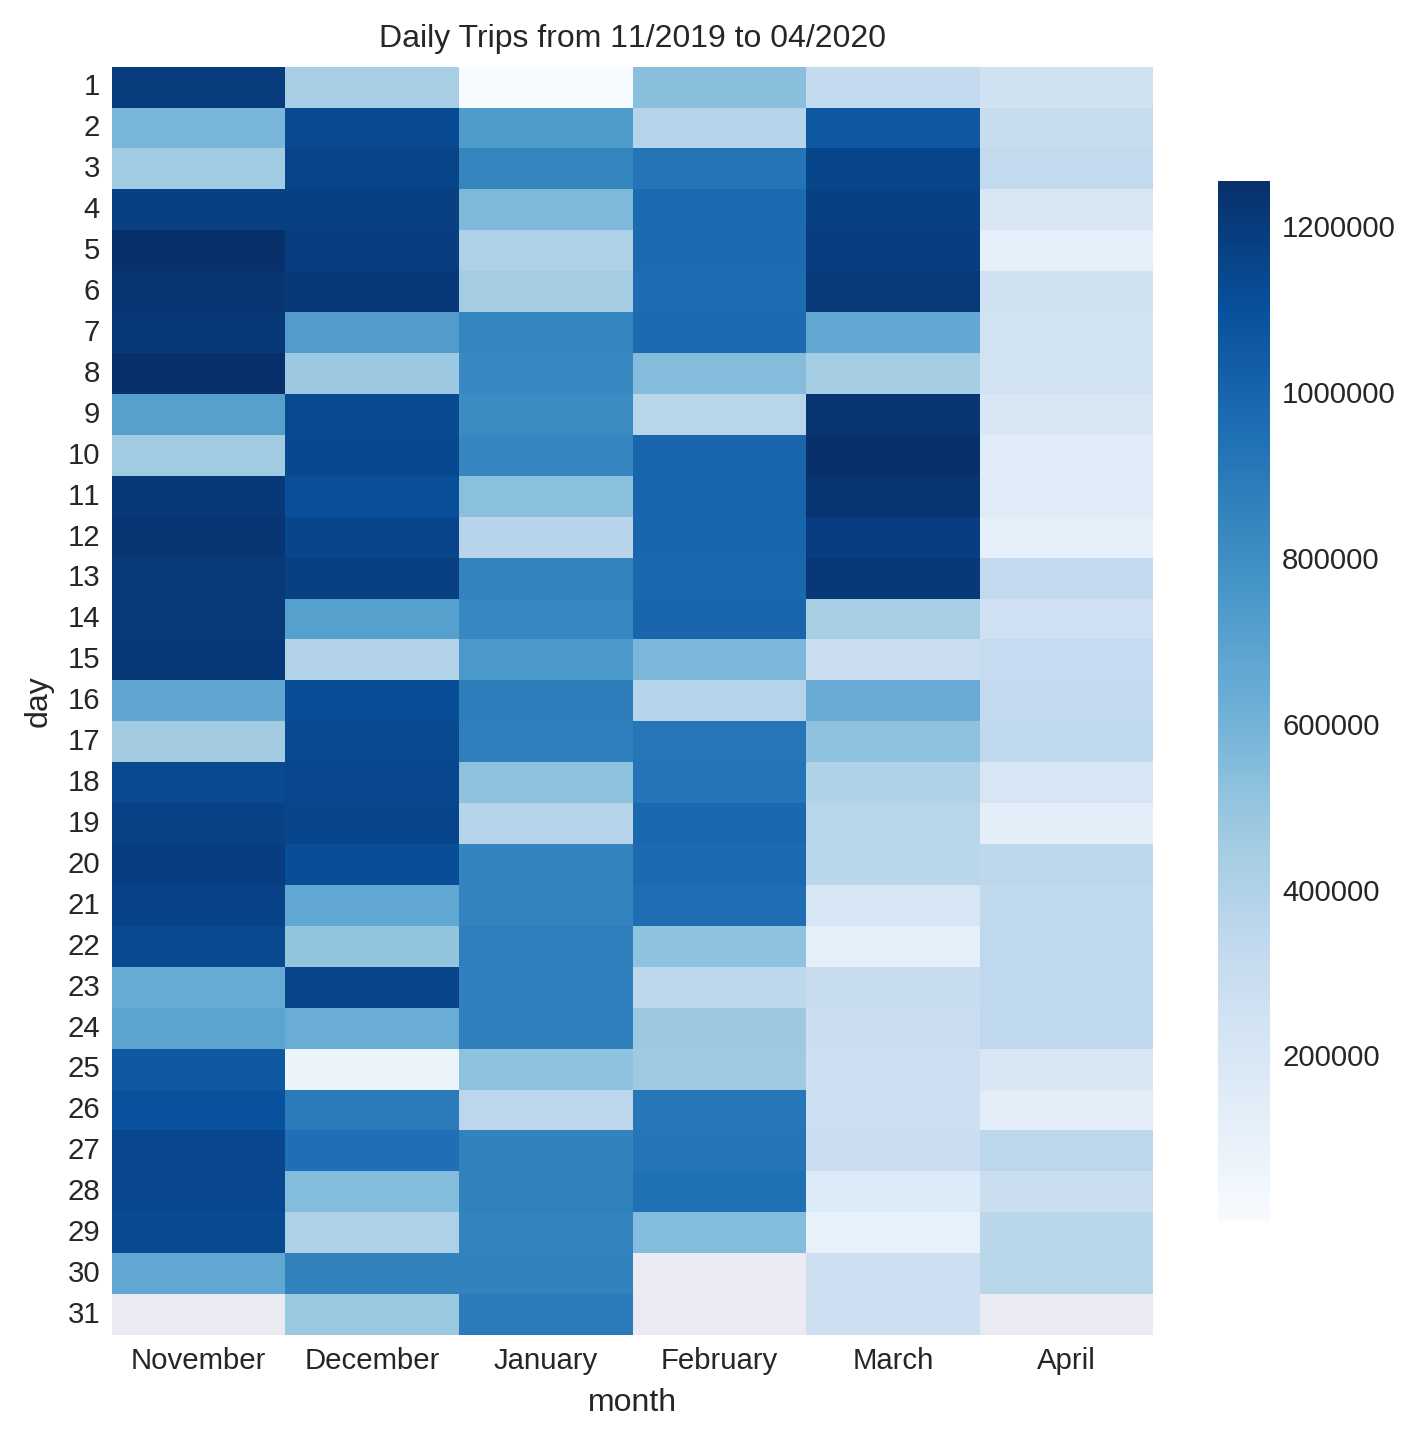

In [26]:
plt.figure(figsize=(7, 7), dpi=120)

daily_trips = pd.read_csv(
    "results/outdaily-trips",
    skipfooter=3,
    delimiter="\t",
    names=["date", "trips"],
    parse_dates=True,
    index_col="date",
    engine="python",
)

daily_trips.info()

data = (
    daily_trips["2019-11":"2020-04"]
    .assign(day=lambda x: x.index.day)
    .assign(month=lambda x: x.index.month_name())
)
data["month"] = data["month"].astype(
    pd.api.types.CategoricalDtype(
        categories=["November", "December", "January", "February", "March", "April"]
    )
)
data_pt = data.pivot_table(index="day", columns="month", values="trips")

ax = sns.heatmap(data=data_pt, cmap="Blues", cbar_kws={"shrink": 0.82, "format": "%.f"})
_ = ax.tick_params(labelrotation=0)
_ = ax.set_title("Daily Trips from 11/2019 to 04/2020")

plt.savefig("daily_trips_hm.png", dpi=300)


Se puede apreciar que en la semana del lunes dieciseis de marzo se dio una baja drástica en el uso del transporte público frente a meses anteriores, se esperaba este resultado dado que el primer caso de COVID19 en Uruguay y la declaración de estado de emergencia nacional sanitaria se dio durante la tarde del día viernes trece de marzo.

## Correlación entre casos de covid y movimiento de la población

(Esperamos que en los pícos de la pandemia disminuzca el uso del transporte)

In [27]:
daily_covid_cases = pd.read_csv(
    "extra_data/estadisticasUY_porDepto.csv",
    usecols=["fecha", "Montevideo(UY-MO)"],
    parse_dates=True,
    infer_datetime_format=True,
    index_col="fecha",
    engine="python",
)
daily_covid_cases.rename(columns={"Montevideo(UY-MO)": "covid_cases"}, inplace=True)

daily_trips_covid = pd.merge(
    daily_trips,
    daily_covid_cases,
    left_index=True,
    right_index=True,
)


In [28]:
daily_trips_covid.corr(method = "pearson").trips.covid_cases

-0.1614168448690401

<AxesSubplot:>

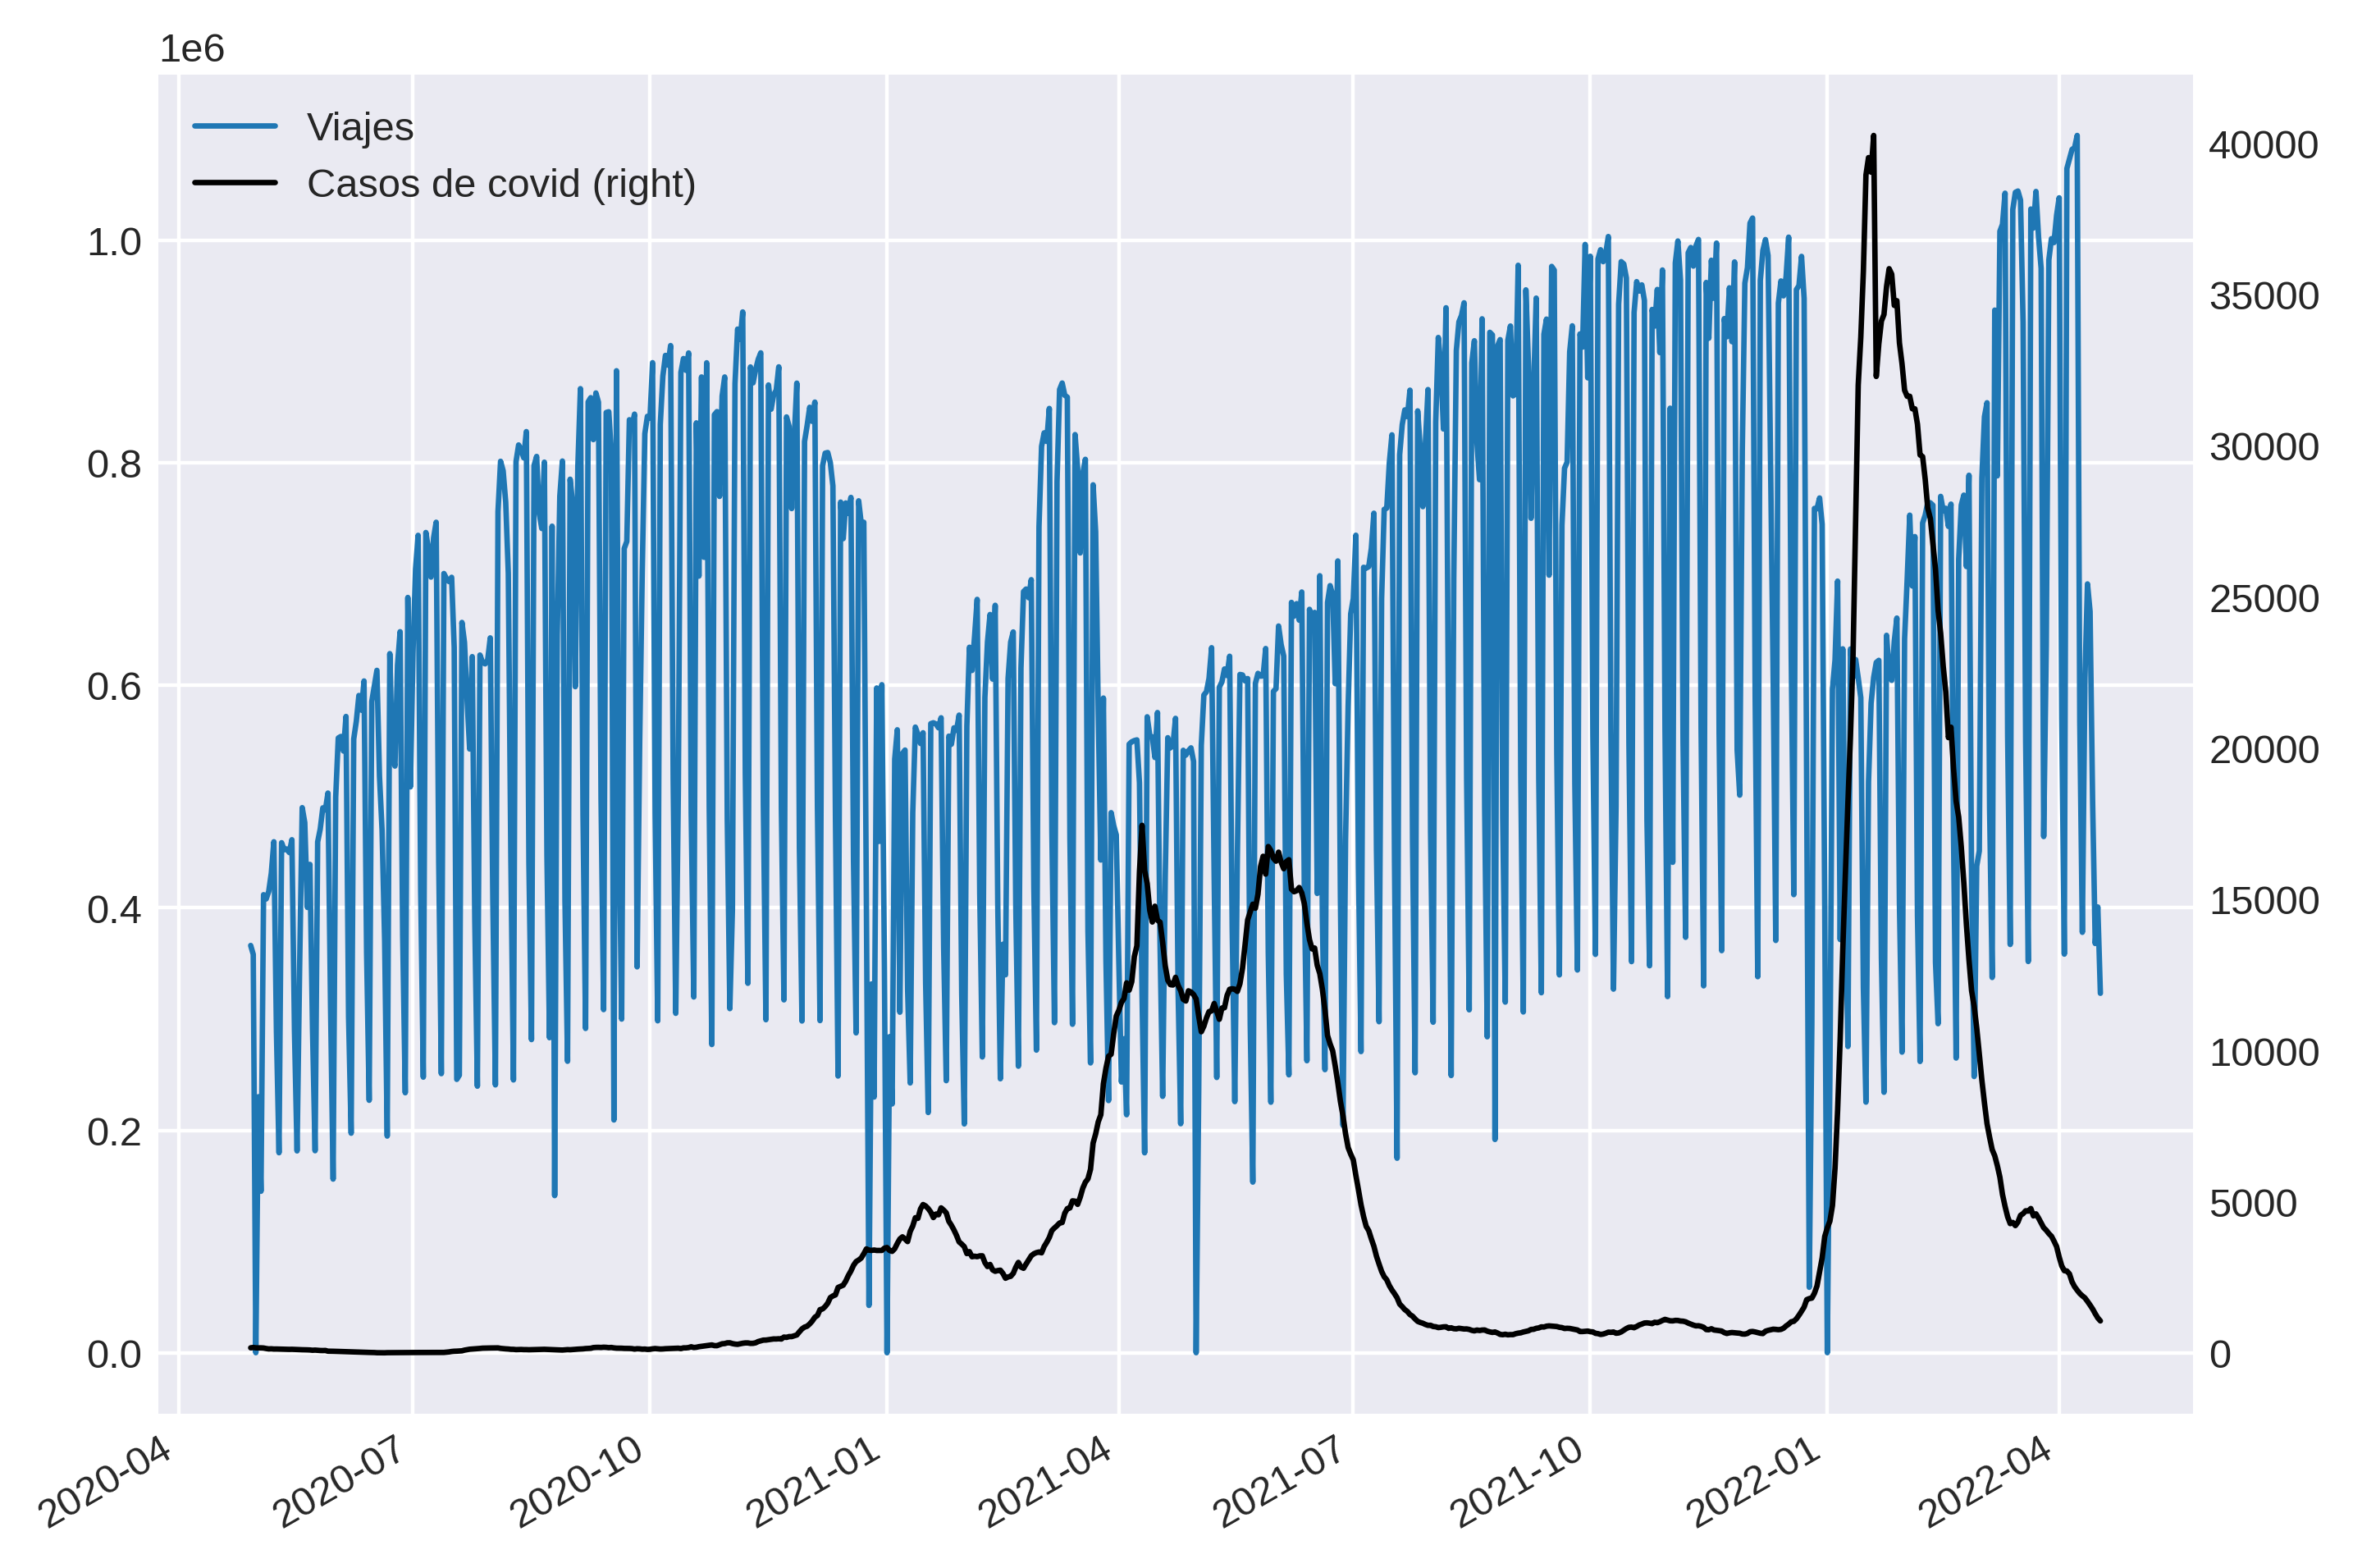

In [29]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

daily_trips_covid.plot(y="trips", ax=ax, grid=True, label="Viajes")
daily_trips_covid.plot(y="covid_cases", ax=ax, secondary_y=True, grid=True, label="Casos de covid", colormap="gray")

# daily_trips_covid["weekday"] = daily_trips_covid.index.weekday
# daily_trips_covid_no_weekend = daily_trips_covid[daily_trips_covid.weekday.isin([0,1,2,3,4])]
# fig, ax = plt.subplots(figsize=(14,10), dpi=120)
# dtest.plot(y = 'trips', ax = ax)
# dtest.plot(y = 'covid_cases', ax = ax, secondary_y = True)


Aunque los coeficientes de correlación parecen no indicar que exista correlación alguna, se observar en el gráfico que durante los aumentos en los casos de covid, el uso del transporte público metropolitano desciende fuertemente, como lo es el caso de noviembre-diciembre 2020, marzo-abril 2021 y diciembre 2021.

<AxesSubplot:>

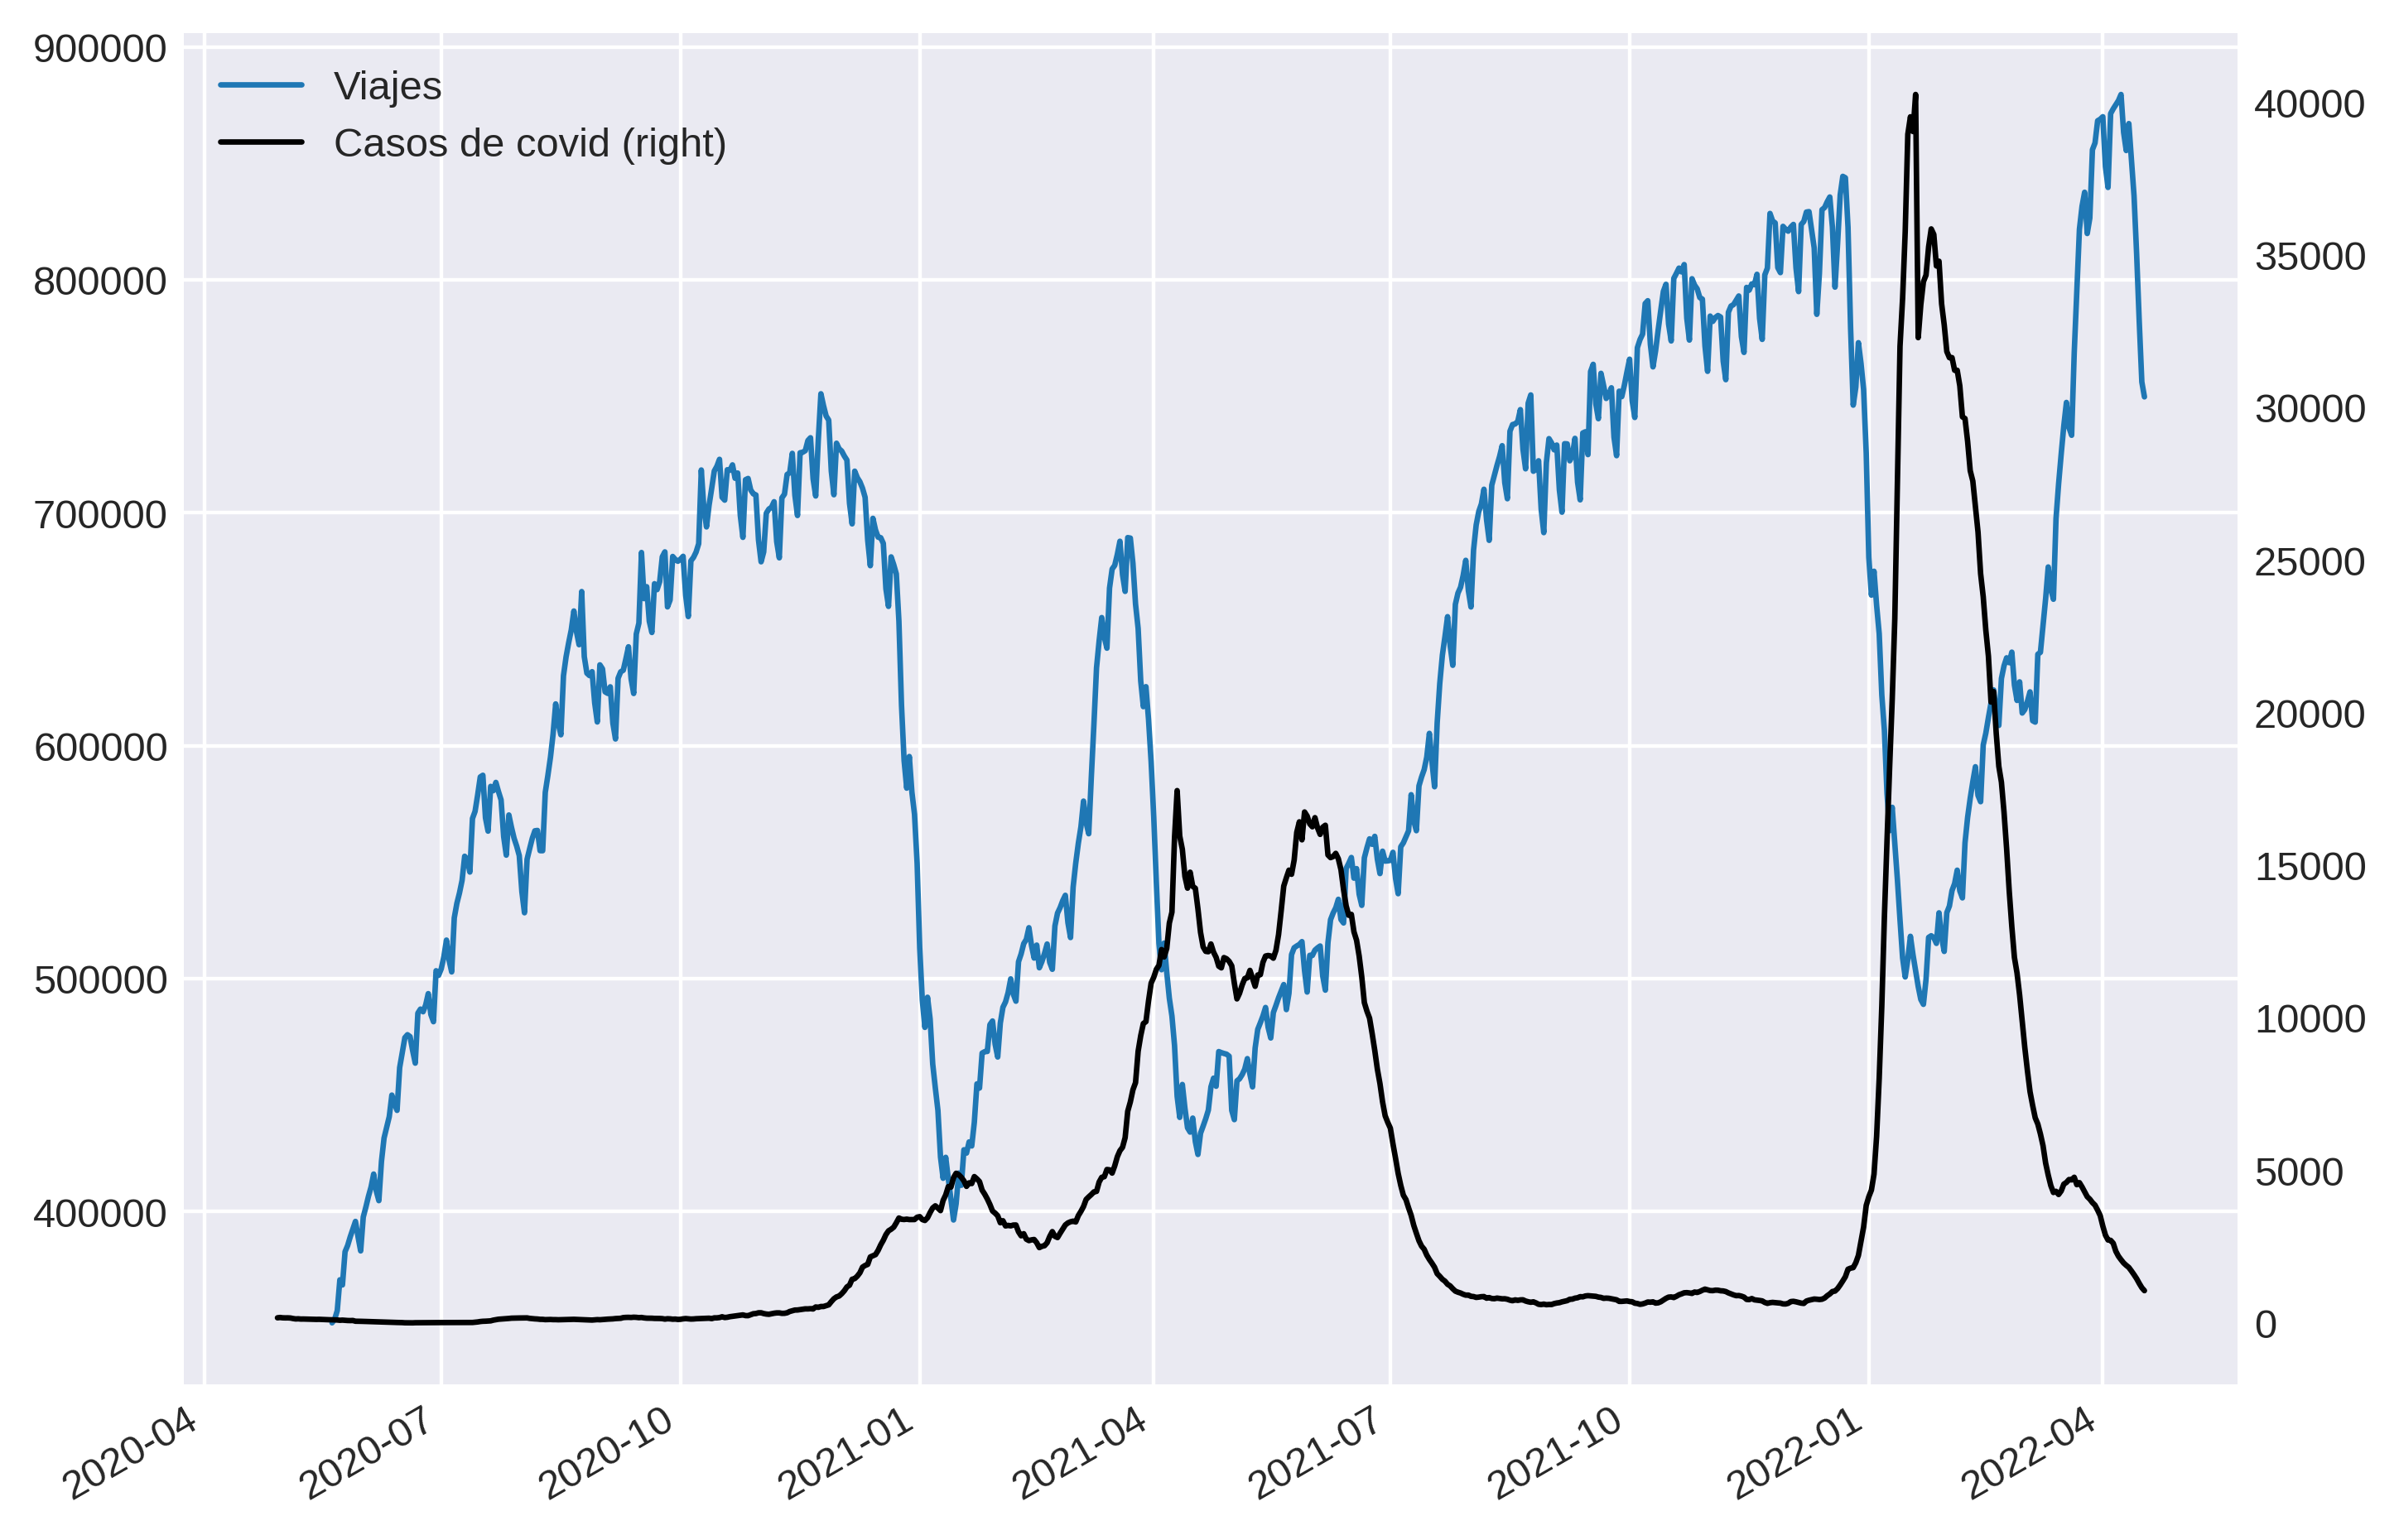

In [30]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

daily_trips_covid["rolling_mean"] = daily_trips_covid["trips"].rolling(window=22).mean()
daily_trips_covid.plot(y="rolling_mean", ax=ax, label="Viajes")
daily_trips_covid.plot(y="covid_cases", ax=ax, secondary_y=True, grid=True, label="Casos de covid", colormap="gray")


In [31]:
daily_trips_covid.corr(method = "pearson").rolling_mean.covid_cases


-0.37510824755236777

Utilizando como valor diario el promedio de viajes de las dos semanas anteriores, se puede observar de manera mas clara la forma en la que varia la cantidad de viajes en base a los casos de covid, además en este caso se obtiene un coeficiente de correlación de pearson de -0.354 lo que indica una correlación negativa ya significativa frente al caso anterior.

In [32]:
# daily_trips_covid["weekday"] = daily_trips_covid.index.weekday
# daily_trips_covid_no_weekend = daily_trips_covid[daily_trips_covid.weekday.isin([0,1,2,3,4])]

# fig, ax = plt.subplots(figsize=(14,10), dpi=120)
# daily_trips_covid_no_weekend.plot(y = 'rolling_mean', ax = ax)
# daily_trips_covid_no_weekend.plot(y = 'covid_cases', ax = ax, secondary_y = True)

# daily_trips_covid_no_weekend.corr(method = "pearson").rolling_mean.covid_cases

## Análisis de movimiento diario

Es de interes conocer como es el uso del transporte público con respecto al barrio, linea de omnibus y grupo de usuario. En esta ocasión lo que se investigara es si se puede determinar que un grupo hace un uso mas crítico del sistema frente a otros, para ello se buscaran cuales son los grupos en los que se da la correlación menos negativa entre los casos de covid y el uso del mismo, esto indicaría que aunque los casos de covid se estuviesen disparando, estas personas igual deben seguir trasladandose a través de omnibus, lo cual iría en contra del uso general, en donde (como fue observado en la sección anterior) el uso decrece cuando los casos suben.

### Por barrio

In [33]:
daily_trips_nb = pd.read_csv(
    "results/outdaily-per-neighborhood",
    skipfooter=3,
    delimiter="\t",
    names=["date_nb", "trips"],
    engine="python",
)

# Split date and neighborhood into two columns
daily_trips_nb[["date", "neighborhood"]] = daily_trips_nb["date_nb"].str.split(
    "_", expand=True
)
daily_trips_nb = daily_trips_nb.drop("date_nb", axis=1)

# Format correctly and set date and neighborhood as multiindex
only_nbs = daily_trips_nb["neighborhood"].apply(lambda x: not x.isnumeric())
daily_trips_nb["neighborhood"] = daily_trips_nb[only_nbs]["neighborhood"].astype(
    "category"
)

daily_trips_nb["date"] = pd.to_datetime(daily_trips_nb["date"])
daily_trips_nb.set_index(["date", "neighborhood"], inplace=True)

# Add covid cases column
daily_trips_nb = pd.merge(
    daily_trips_nb, daily_covid_cases, left_on="date", right_index=True
)

# Remove NaN values corresponding to trips that started on an unknown bus stop
index_names = daily_trips_nb.index.names
daily_trips_nb = daily_trips_nb.reset_index().dropna().set_index(index_names)

daily_trips_nb.info()
# print(daily_trips_nb.head())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 46504 entries, (Timestamp('2020-04-29 00:00:00'), 'AGUADA') to (Timestamp('2022-04-17 00:00:00'), 'VILLA MUÃ‘OZ, RETIRO')
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   trips        46504 non-null  int64
 1   covid_cases  46504 non-null  int64
dtypes: int64(2)
memory usage: 887.4 KB


/tmp/ipykernel_26829/3477226592.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correlations = daily_trips_nb.groupby(["neighborhood"])[


<AxesSubplot:ylabel='Barrio'>

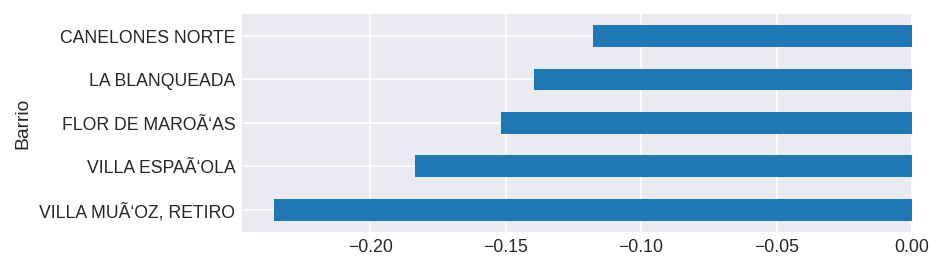

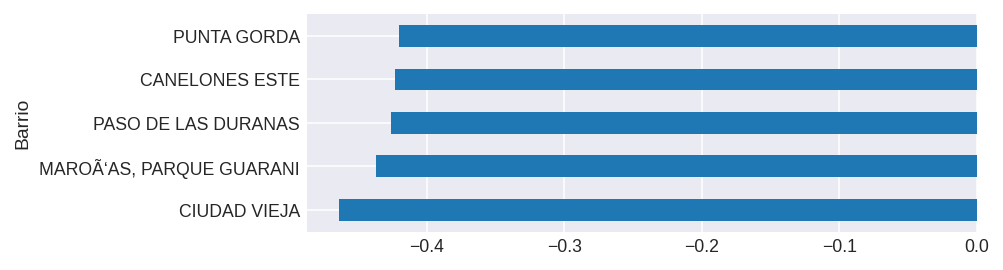

In [34]:
daily_trips_nb["rolling_mean"] = daily_trips_nb.groupby(level="neighborhood")[
    "trips"
].apply(lambda x: x.rolling(window=22).mean())

# daily_trips_nb.info()

correlations = daily_trips_nb.groupby(["neighborhood"])[
    "rolling_mean", "covid_cases"
].corr(method="pearson")

correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].sort_values("rolling_mean").iloc[-5:, :].plot(
    kind="barh",
    figsize=(6, 2),
    # title="Correlación entre casos de covid y viajes en omnibus por barrio",
    grid=True,
    xlabel="Barrio",
    legend=False,
)
correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].sort_values("rolling_mean").iloc[:5, :].plot(
    kind="barh",
    figsize=(6, 2),
    # title="Correlación entre casos de covid y viajes en omnibus por barrio",
    grid=True,
    xlabel="Barrio",
    legend=False,
)

Ciudad Vieja, Paso de las Duranas, Canelones (al este), Punta Gorda y Barrio Sur son los barrios en los que el uso del transporte público varió mas en base a los casos de covid, las personas que viven en estos barrios dejaban de utilizar el sistema metropolitano a medida que la cantidad de casos de covid subían y lo volvían a utilizar en cuanto bajaban. Mientras que en Canelones (al norte), La Blanqueada, Flor de Maroñas y Villa Española el uso del transporte metropolitano no se ajusto tanto a la variación de casos de covid. Por ejemplo, comparando Ciudad Vieja y La Blanqueada se tiene que

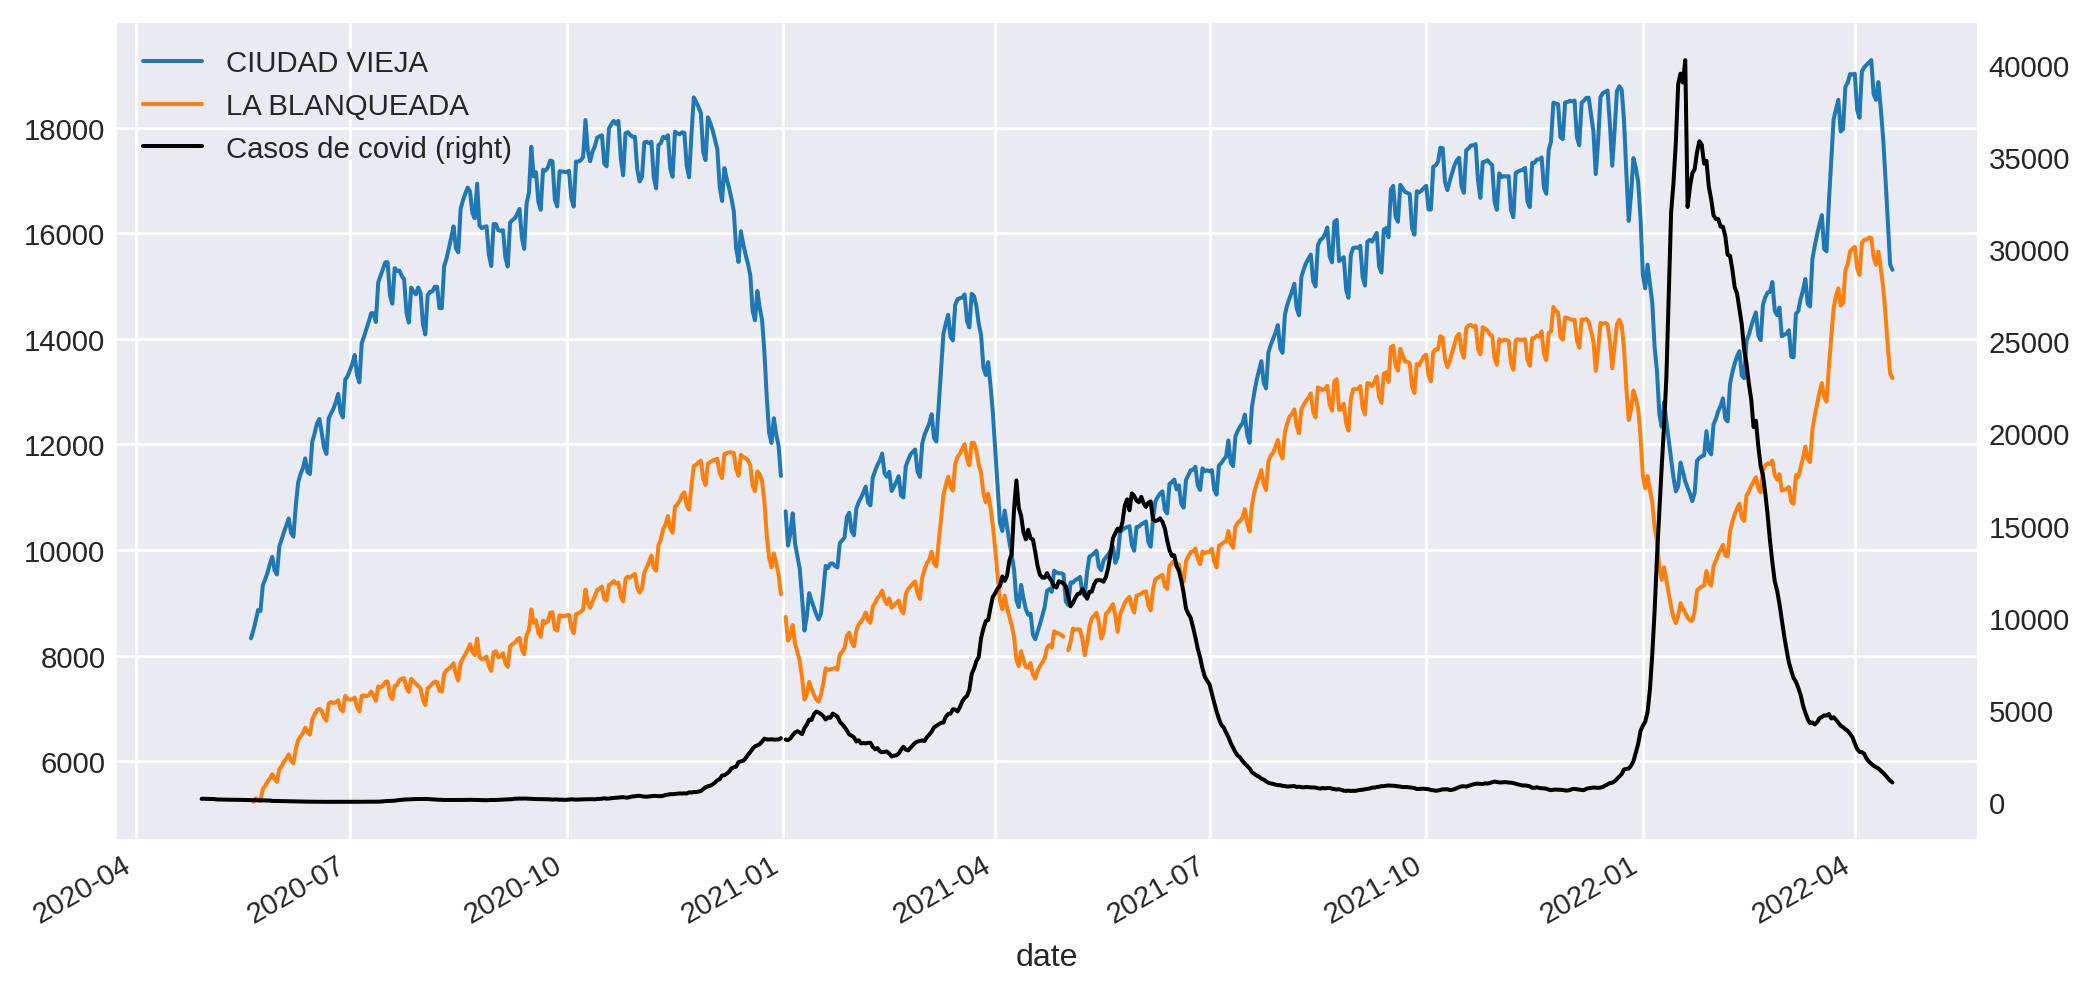

In [35]:
nb_by_column = daily_trips_nb.unstack()

def plot_nb(neighborhood1: str, neighborhood2: str):
    fig, ax = plt.subplots(figsize=(10,5), dpi=120)

    nb_by_column["rolling_mean"].plot(y = neighborhood1, ax = ax)
    nb_by_column["rolling_mean"].plot(y = neighborhood2, ax = ax)
    nb_by_column["covid_cases"].plot(y = neighborhood1, ax = ax, label="Casos de covid", secondary_y=True, colormap="gray", grid=True)

plot_nb("CIUDAD VIEJA", "LA BLANQUEADA")#Ã‘


En el caso de Ciudad Vieja, el uso del transporte público bajo intensamente durante cada pico de casos de covid, mientras que en el caso de La Blanqueada, aunque la figura es similar y baja el uso durante cada pico, esta baja del uso no es con la intensidad del caso anterior.

### Por linea

In [36]:
daily_trips_busline = pd.read_csv(
    "results/outdaily-per-busline",
    skipfooter=3,
    delimiter="\t",
    names=["date_bl", "trips"],
    engine="python",
)

# Split date and neighborhood into two columns
daily_trips_busline[["date", "busline"]] = daily_trips_busline["date_bl"].str.split(
    "_", expand=True
)
daily_trips_busline = daily_trips_busline.drop("date_bl", axis=1)

# Format correctly and set date and neighborhood as multiindex
daily_trips_busline["busline"] = daily_trips_busline["busline"].astype("category")
daily_trips_busline["date"] = pd.to_datetime(daily_trips_busline["date"])
daily_trips_busline.set_index(["date", "busline"], inplace=True)

# Add covid cases column
daily_trips_busline = pd.merge(
    daily_trips_busline, daily_covid_cases, left_on="date", right_index=True
)
daily_trips_busline.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 89553 entries, (Timestamp('2020-04-29 00:00:00'), '100') to (Timestamp('2022-04-17 00:00:00'), 'L7')
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   trips        89553 non-null  int64
 1   covid_cases  89553 non-null  int64
dtypes: int64(2)
memory usage: 1.7 MB


/tmp/ipykernel_26829/4063133834.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correlations = filtered_df.groupby(["busline"])[


rolling_mean   -0.074376
dtype: float64

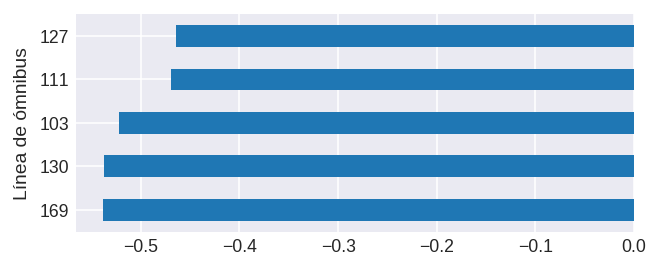

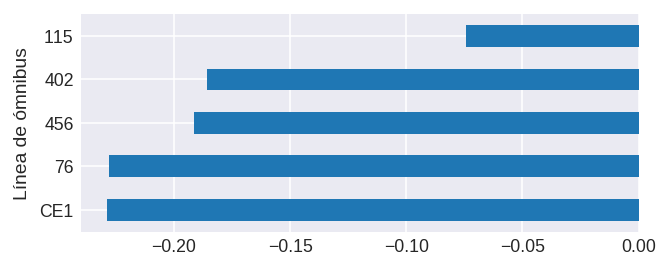

In [37]:
daily_trips_busline["rolling_mean"] = daily_trips_busline.groupby(level="busline")["trips"].apply(lambda x: x.rolling(window=22).mean())

# Filter out buslines with less than 100000 trips
filtered_df = daily_trips_busline[daily_trips_busline.groupby(level=1)["trips"].transform("sum").gt(1500000)]
correlations = filtered_df.groupby(["busline"])[
    "rolling_mean", "covid_cases"
].corr(method="pearson")

correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].sort_values("rolling_mean").iloc[:5, :] .plot(
    kind="barh",
    figsize=(5,2),
    grid=True,
    xlabel="Línea de ómnibus",
    legend=False,
)
correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].sort_values("rolling_mean").iloc[-5:, :] .plot(
    kind="barh",
    figsize=(5,2),
    grid=True,
    xlabel="Línea de ómnibus",
    legend=False,
)
correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].max()

Las líneas donde se da una correlación negativa mas fuerte son la 103, 130 y 169, tomando un valor menor a -0.5. Observando el otro extremo se puede apreciar que en la línea 115 se da la correlación mas débil, con un valor de -0.074 y luego la siguen las líneas 402 y 456, tomando un valor aproximado de -0.180.

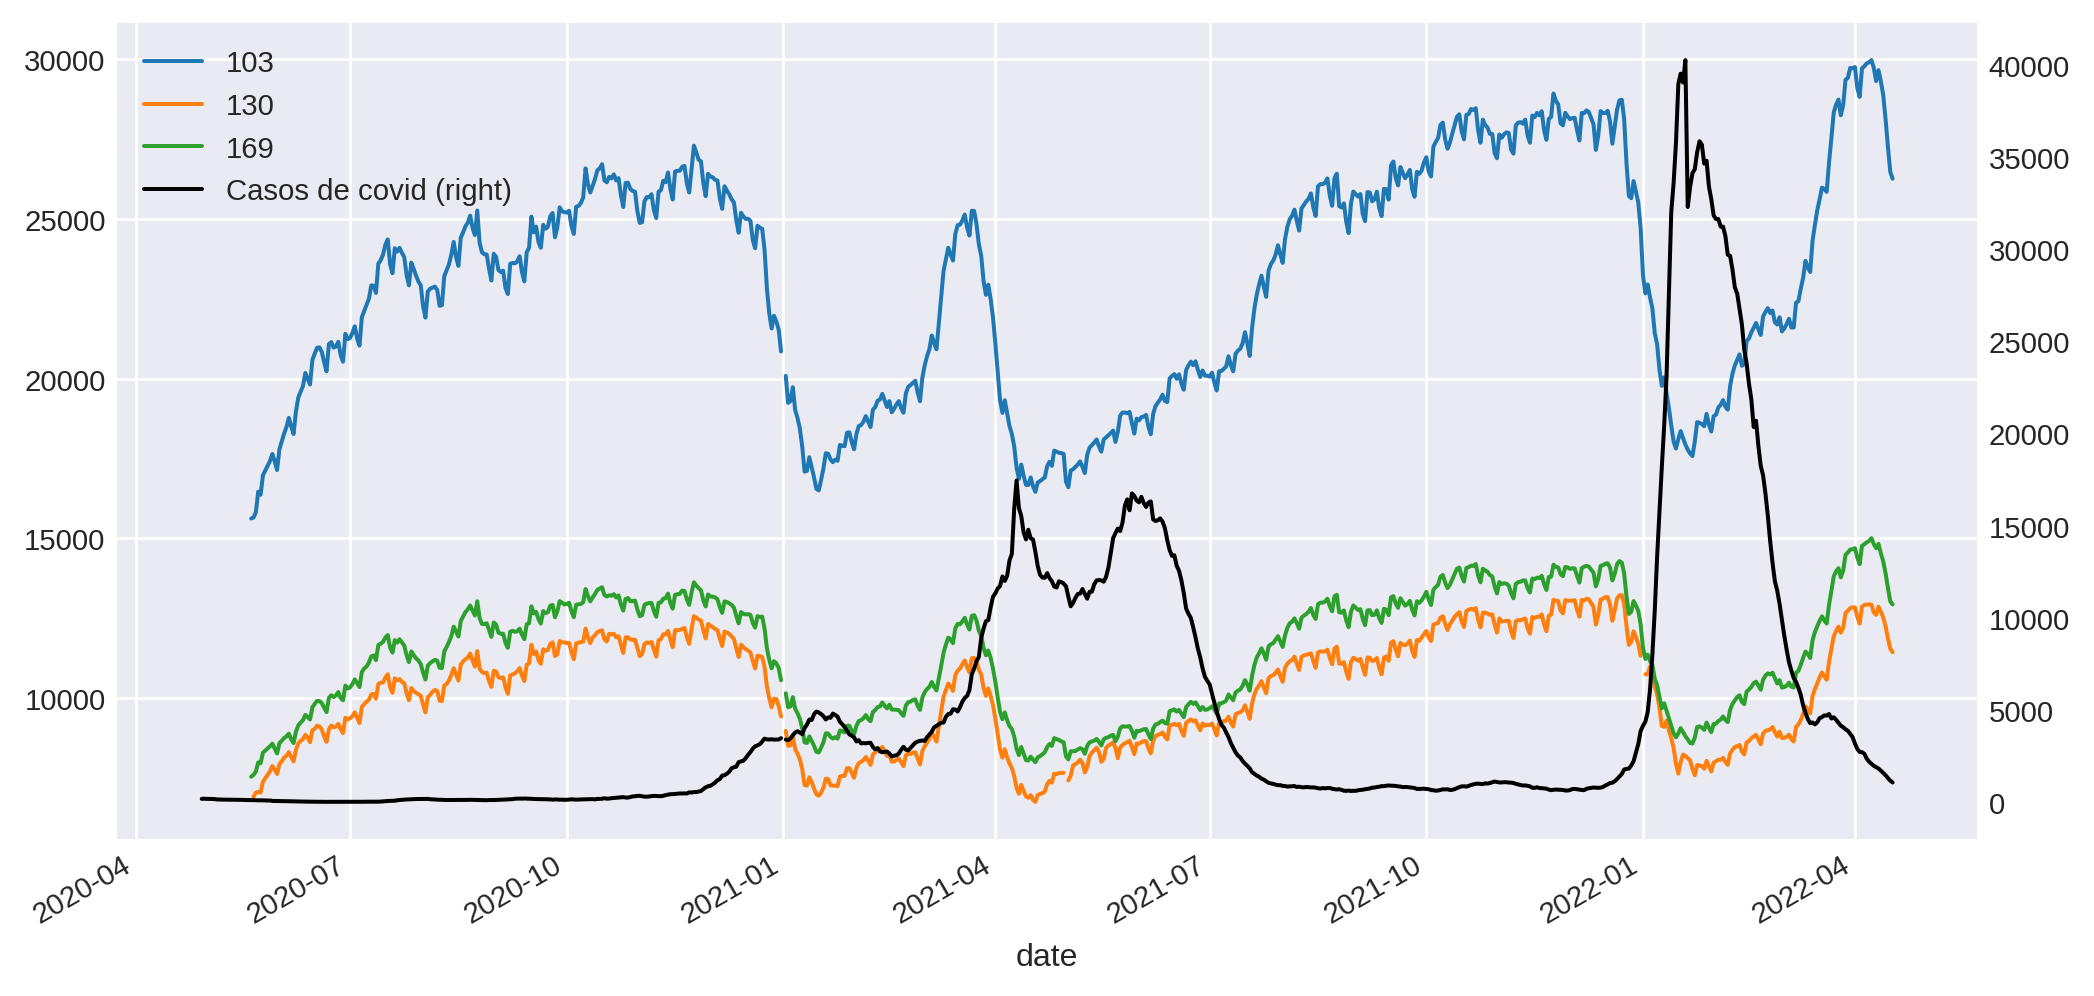

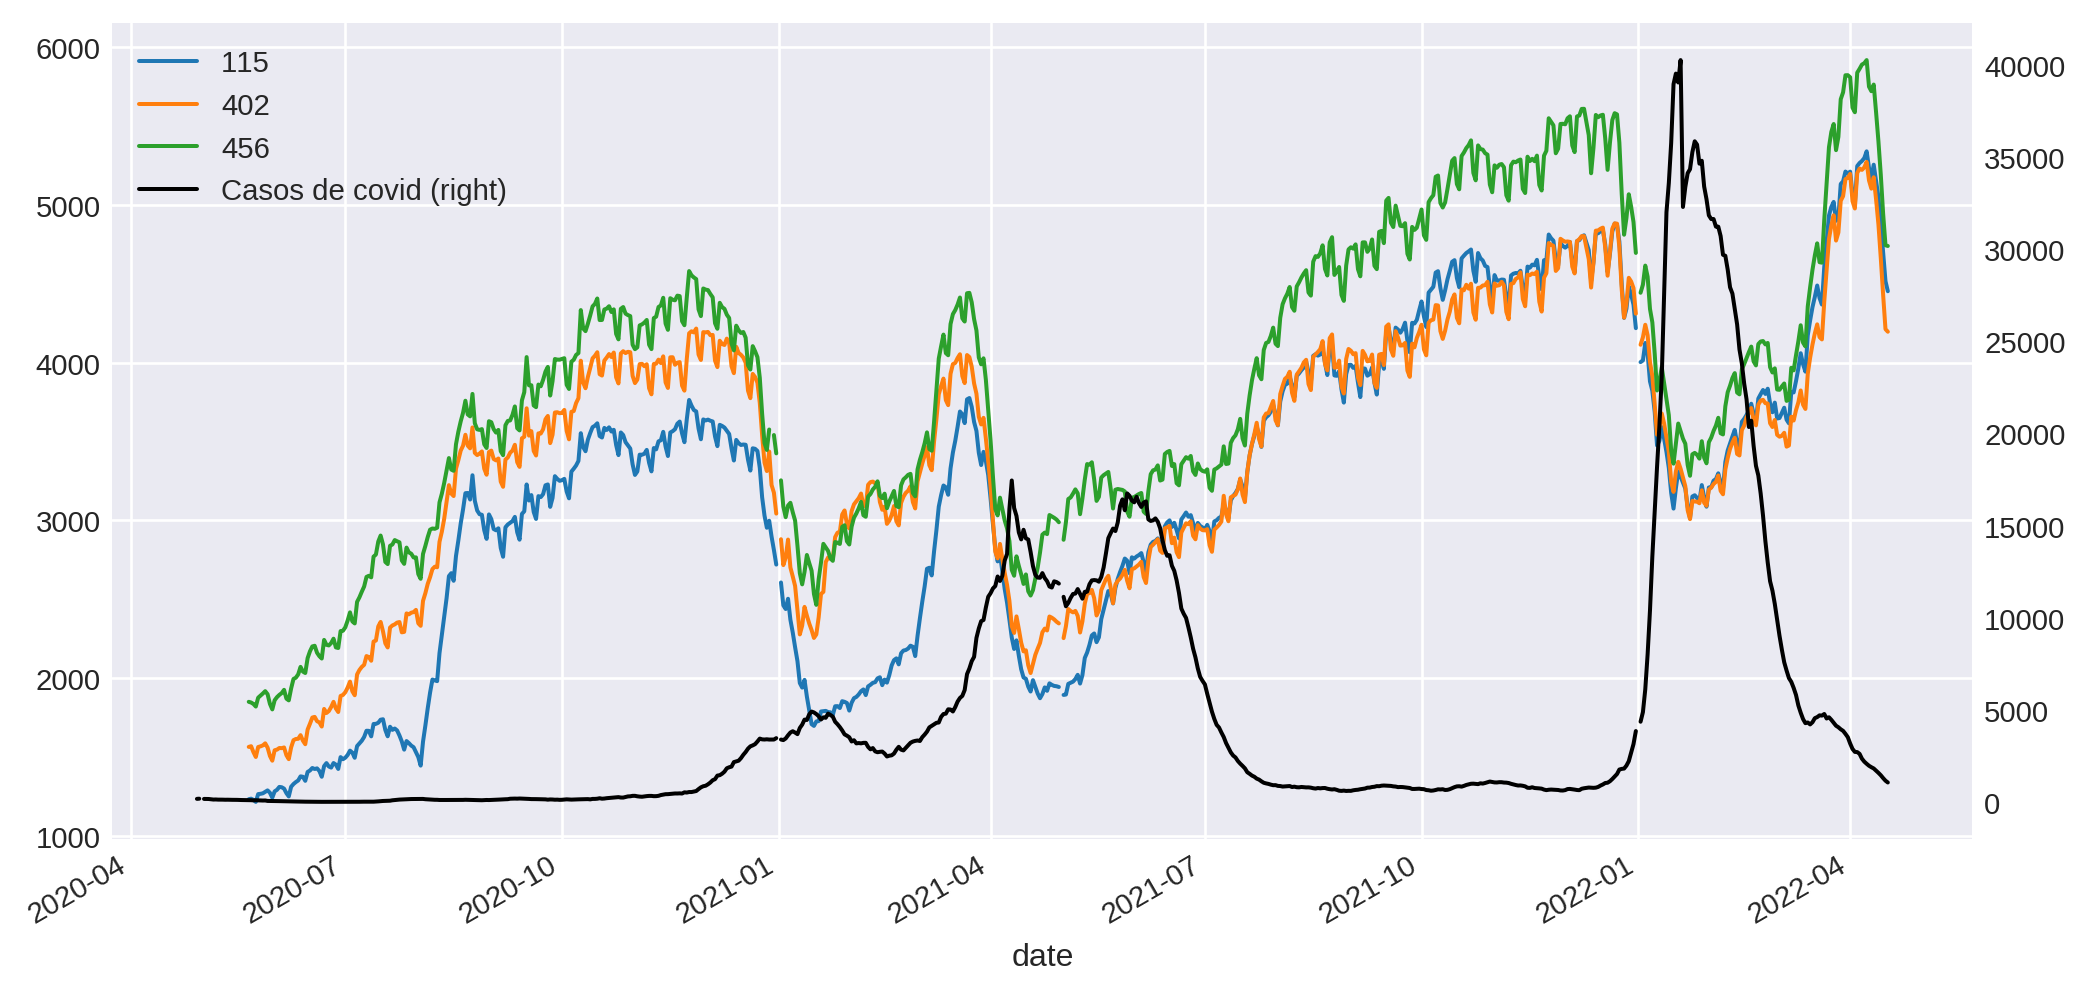

In [38]:
busline_by_column = daily_trips_busline.unstack()

def plot_busline(buslines):
    fig, ax = plt.subplots(figsize=(10,5), dpi=120)

    for busline in buslines:
        busline_by_column["rolling_mean"].plot(y = busline, ax = ax)

    busline_by_column["covid_cases"].plot(y = buslines[0], ax = ax, label="Casos de covid", secondary_y=True, colormap="gray", grid=True)

plot_busline(["103", "130", "169"])

plot_busline(["115", "402", "456"])

Al igual que en el caso de los barrios, las caídas del uso de las líneas 103, 130 y 169 son mas prominentes que en el caso de las líneas 115, 402 y 456. Lo que lleva a suponer que menos usuarios de esas líneas podían elegir quedarse en casa o utilizar otro medio de transporte.

### Por grupo de usuario

In [39]:
daily_trips_usertype = pd.read_csv(
    "results/outdaily-per-usertype",
    skipfooter=3,
    delimiter="\t",
    names=["date_ut", "trips"],
    engine="python",
)

# Split date and usertype into two columns
daily_trips_usertype[["date", "usertype"]] = daily_trips_usertype["date_ut"].str.split(
    "_", expand=True
)
daily_trips_usertype = daily_trips_usertype.drop("date_ut", axis=1)

# Format correctly and set date and usertype as multiindex
# only_user_types = daily_trips_usertype["usertype"].str.isalnum()
daily_trips_usertype["usertype"] = daily_trips_usertype["usertype"].astype("category")
daily_trips_usertype["date"] = pd.to_datetime(daily_trips_usertype["date"])
daily_trips_usertype.set_index(["date", "usertype"], inplace=True)

# Add covid cases column
daily_trips_usertype = pd.merge(
    daily_trips_usertype, daily_covid_cases, left_on="date", right_index=True
)
# daily_trips_usertype.info()

/tmp/ipykernel_26829/1067624473.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  correlations = filtered_df.groupby(["usertype"])[


rolling_mean    0.064728
dtype: float64

<Figure size 1600x2000 with 0 Axes>

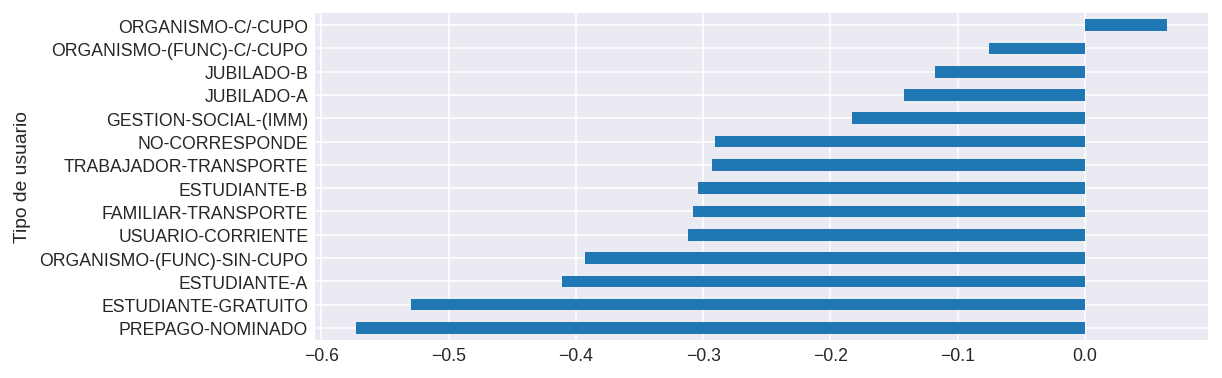

In [40]:
daily_trips_usertype["rolling_mean"] = daily_trips_usertype.groupby(level="usertype")[
    "trips"
].apply(lambda x: x.rolling(window=22).mean())

filtered_df = daily_trips_usertype[daily_trips_usertype.groupby(level=1)["trips"].transform("sum").gt(1000000)]
correlations = filtered_df.groupby(["usertype"])[
    "rolling_mean", "covid_cases"
].corr(method="pearson")

fig = plt.figure(dpi=200)

correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].sort_values("rolling_mean").plot(
    kind="barh",
    figsize=(8,3),
    grid=True,
    xlabel="Tipo de usuario",
    legend=False,
)
correlations[correlations.index.get_level_values(1) == "rolling_mean"].unstack()[
    "covid_cases"
].max()


Se observan 3 niveles de correlación, el primero que abarca a los organismos con cupos, los jubilados y la gestion social de la IMM, donde se da la menor correlación, el segundo desde los que pagan en efectivo, usuario corrientes, estudiantes de tipo B y personas relacionadas al transporte. Y el último formado por estudiantes de boleto gratuito y de tipo A, y también aquellas personas pertenecientes a organismos sin cupo o con una tarjeta prepaga nominada. Se hara enfasis en los jubilados, estudiantes y usuarios corrientes.

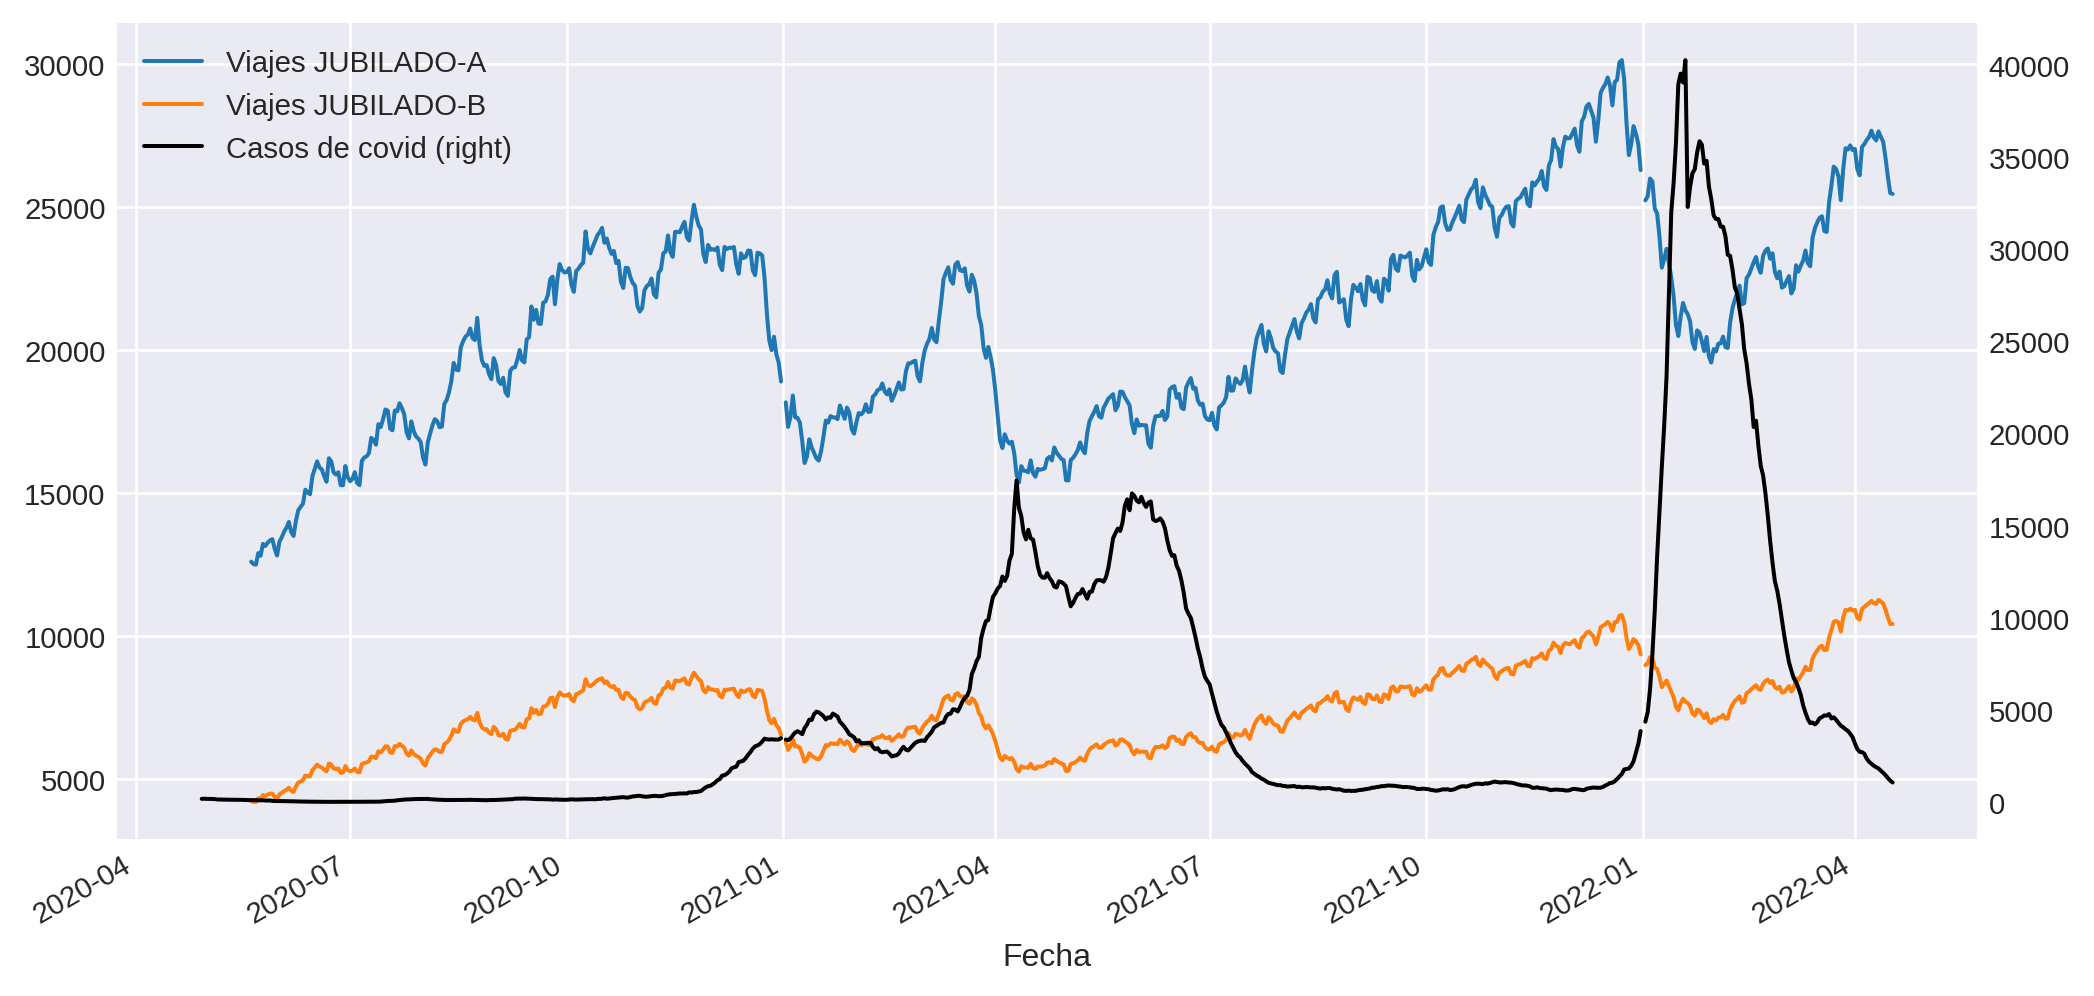

In [41]:
usertype_by_column = daily_trips_usertype.unstack()

def plot_usertype(usertypes):
    fig, ax = plt.subplots(figsize=(10,5), dpi=120)

    for usertype in usertypes:
        usertype_by_column["rolling_mean"].plot(y = usertype, ax = ax, label=f"Viajes {usertype}")

    usertype_by_column["covid_cases"].plot(y = usertypes[0], ax = ax, label="Casos de covid", secondary_y=True, colormap="gray", grid=True)
    
    ax.set_xlabel("Fecha")

plot_usertype(["JUBILADO-A", "JUBILADO-B"])

Aunque durante los picos se observa una baja en el uso del transporte público por parte de los jubilados, esta baja no es tan significativa, sobretodo comparando la cantidad de viajes de junio 2020 con los picos del verano 2021, el período abril-julio 2021 y verano 2022.

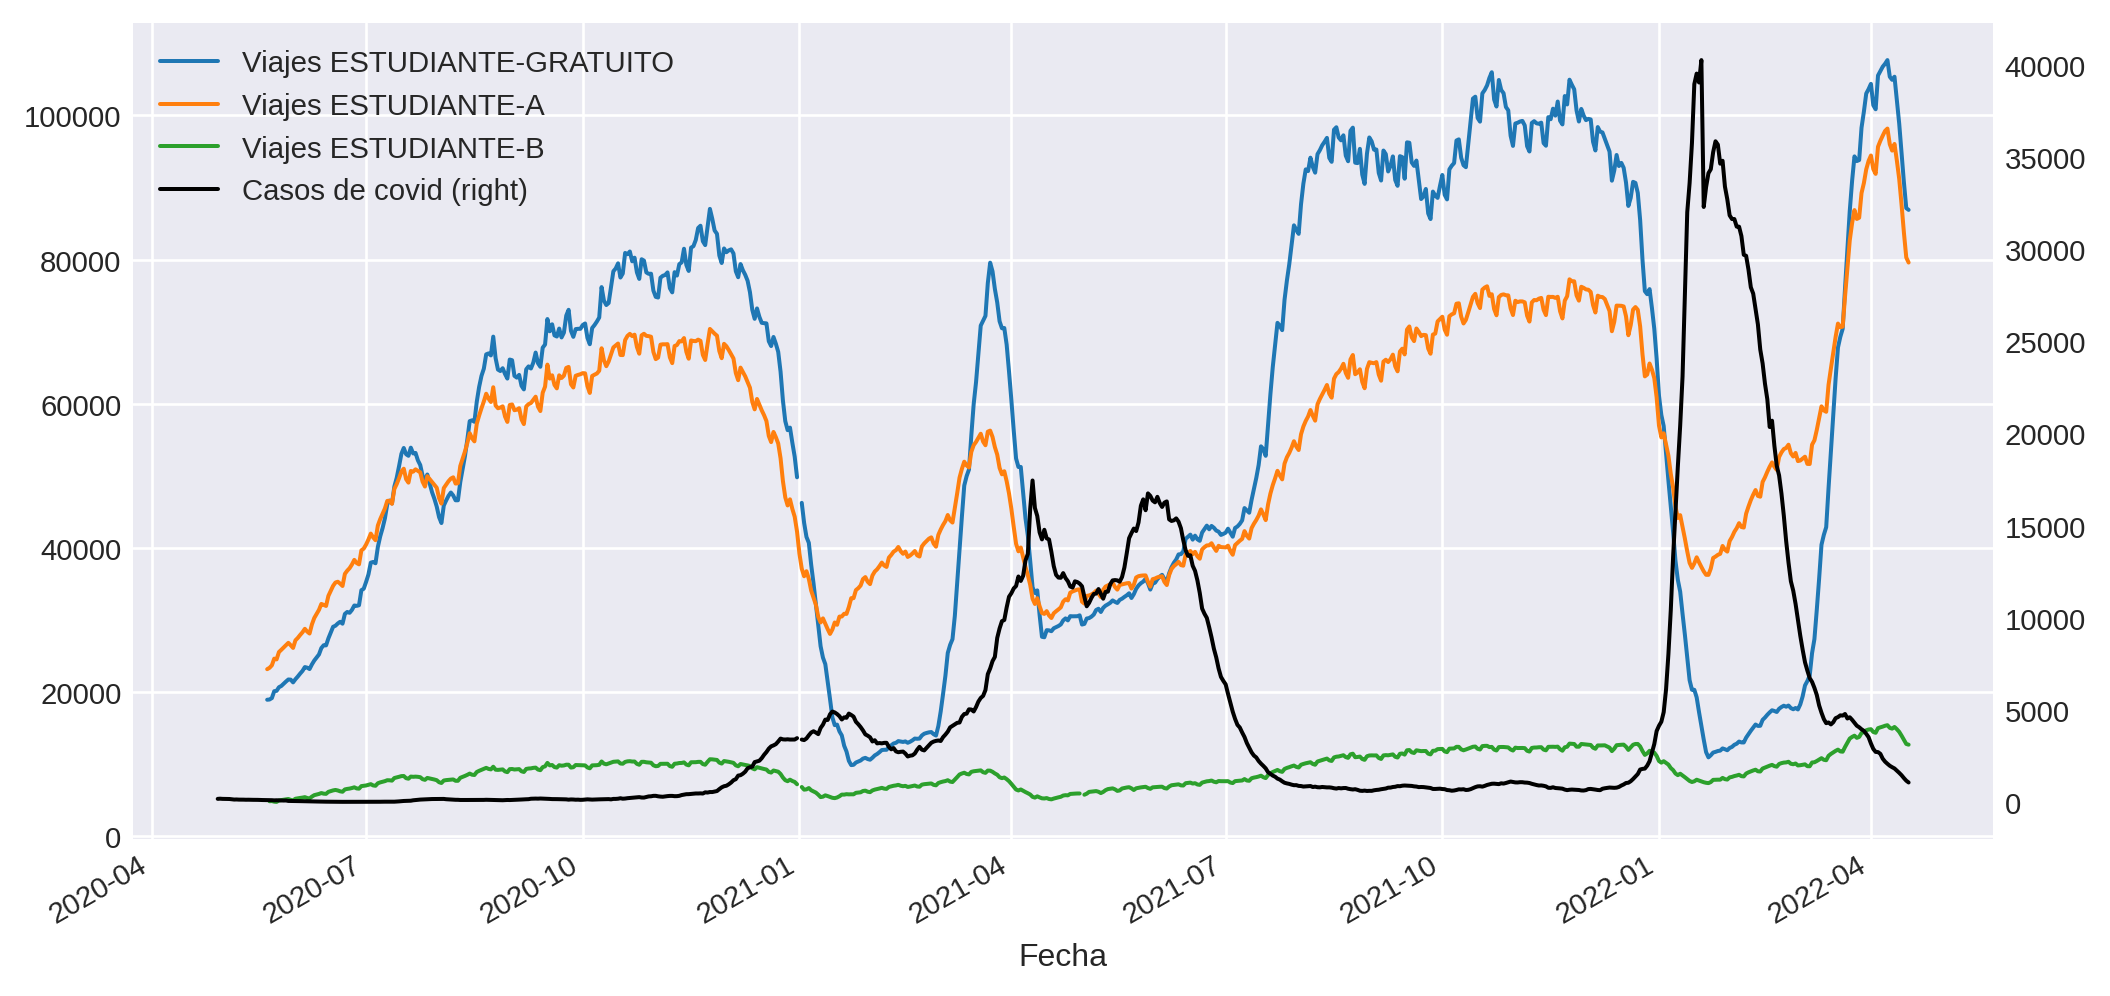

In [42]:
plot_usertype(["ESTUDIANTE-GRATUITO", "ESTUDIANTE-A", "ESTUDIANTE-B"])

Dado que durante enero y febrero los estudiantes no tienen clases, se nota una baja muy fuerte en viajes durante esos meses, que en este caso, coinciden con los picos de verano 2021 y verano 2022. Dejando de lado esos períodos de tiempo, los estudiantes liceales, de categoría A (universitarios o liceales mayores a 18 años y menores a 30 años) y B (mayores de 30) disminuyen su utilización del transporte público al comienzo de cada pico, lo cual coincide con las multiples suspenciones de clases presenciales que ocurrieron durante el transcurso de la emergencia sanitaria, observar Julio 2021 (https://www.anep.edu.uy/15-d/el-lunes-19-anep-completar-el-regreso-presencialidad-con-educaci-n-media#:~:text=El%20pr%C3%B3ximo%20lunes%2019%20de,de%20Secundaria%20y%20T%C3%A9cnico%20Profesional.) y Junio 2020 (https://www.gub.uy/presidencia/comunicacion/noticias/gobierno-anuncio-retorno-presencial-voluntario-clases-partir-junio).

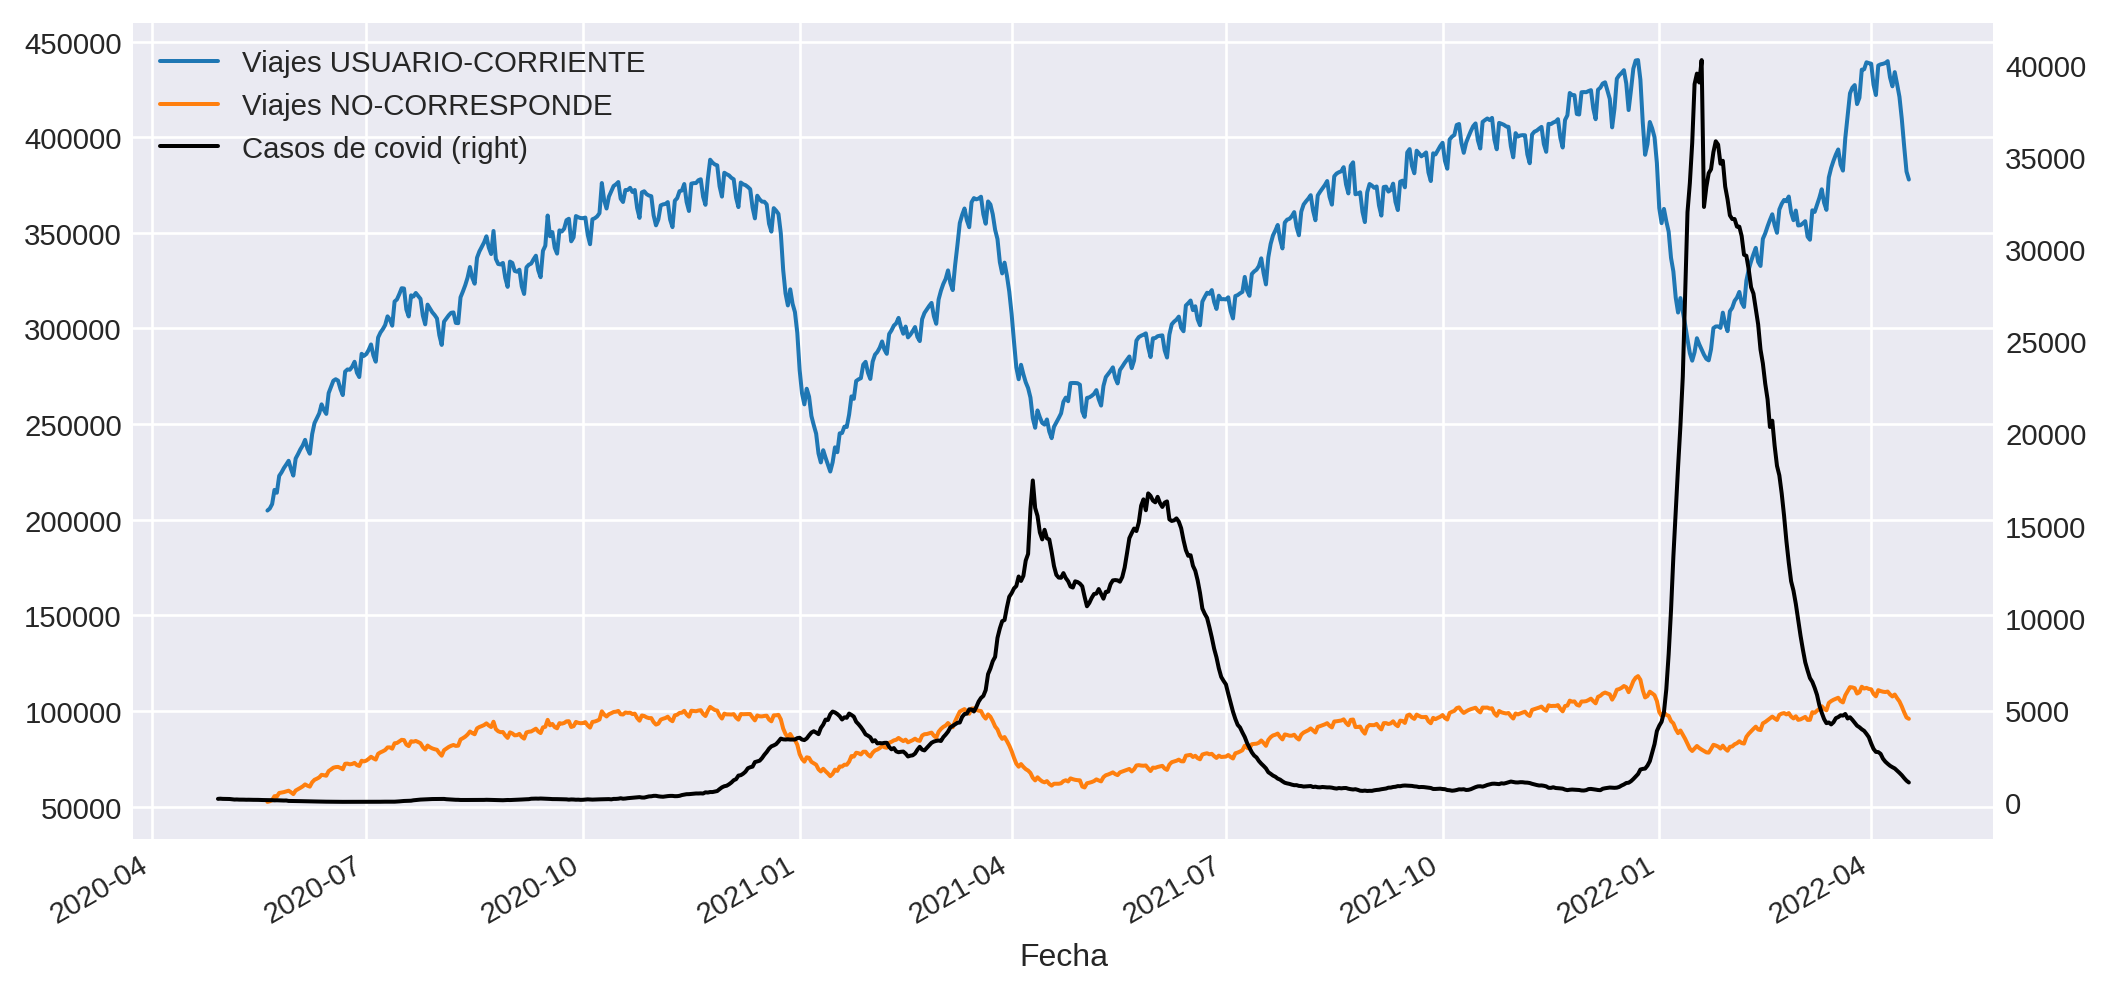

In [43]:
plot_usertype(["USUARIO-CORRIENTE", "NO-CORRESPONDE"])

El usuario corriente se comporta como se espera, es decír, responde a los picos de la pandemia, pero de una forma no tan abrupta como el caso de los estudiantes, ni tan suave como en el caso de los jubilados.

## Estudio de recuperación del movimiento de la ciudad durante la pandemia

Se declaró el fin de la emergencia nacional sanitaria el día 5 de abril del 2022: https://www.gub.uy/sistema-nacional-emergencias/comunicacion/noticias/fin-emergencia-nacional-sanitaria.

Se espera que la utilización del trasporte publico vuelva a la normalidad cerca de esa fecha.

/tmp/ipykernel_26829/3850539888.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  daily_trips = pd.read_csv('results/outdaily-trips', skipfooter=3, delimiter="\t", names=["date", "trips"], parse_dates=True, index_col="date")


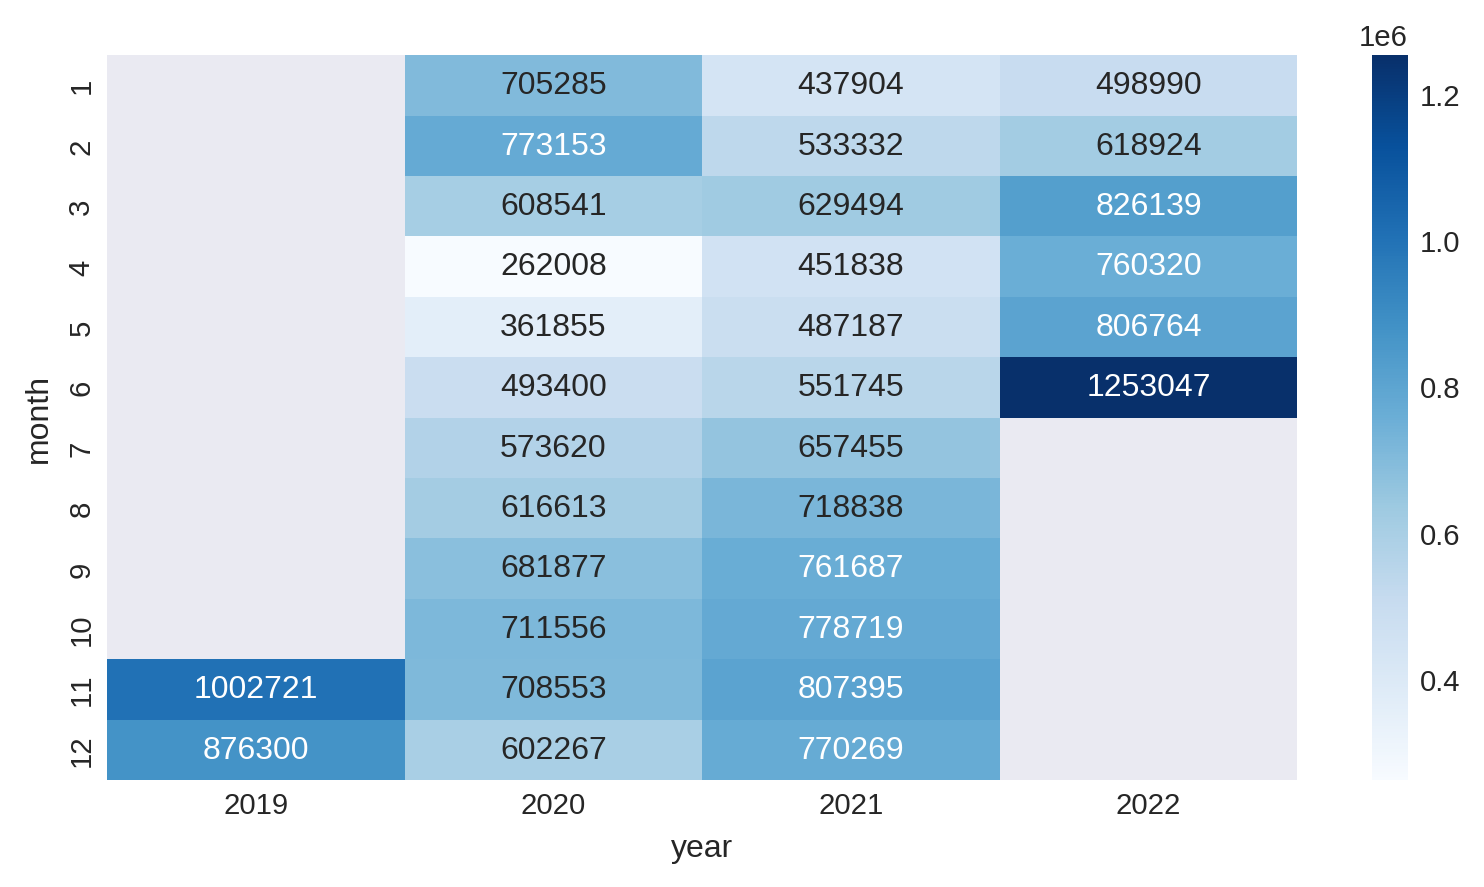

In [44]:
plt.figure(figsize=(8, 4), dpi=120)

daily_trips = pd.read_csv('results/outdaily-trips', skipfooter=3, delimiter="\t", names=["date", "trips"], parse_dates=True, index_col="date")
per_month = daily_trips.groupby(pd.Grouper(freq='M')).mean()

# Per month
data = per_month['2019':'2022']\
        .assign(month=lambda x: x.index.month)\
        .assign(year=lambda x: x.index.year)\
        .pivot_table(index='month', columns='year', values='trips', aggfunc='sum')

ax = sns.heatmap(data=data, cmap="Blues", annot=True, fmt='.0f')
# _ = ax.set_title("Month Trips 01/03/2020 - 20/06/2022")

/tmp/ipykernel_26829/84076260.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  daily_trips = pd.read_csv('results/outdaily-trips', skipfooter=3, delimiter="\t", names=["date", "trips"], parse_dates=True, index_col="date")


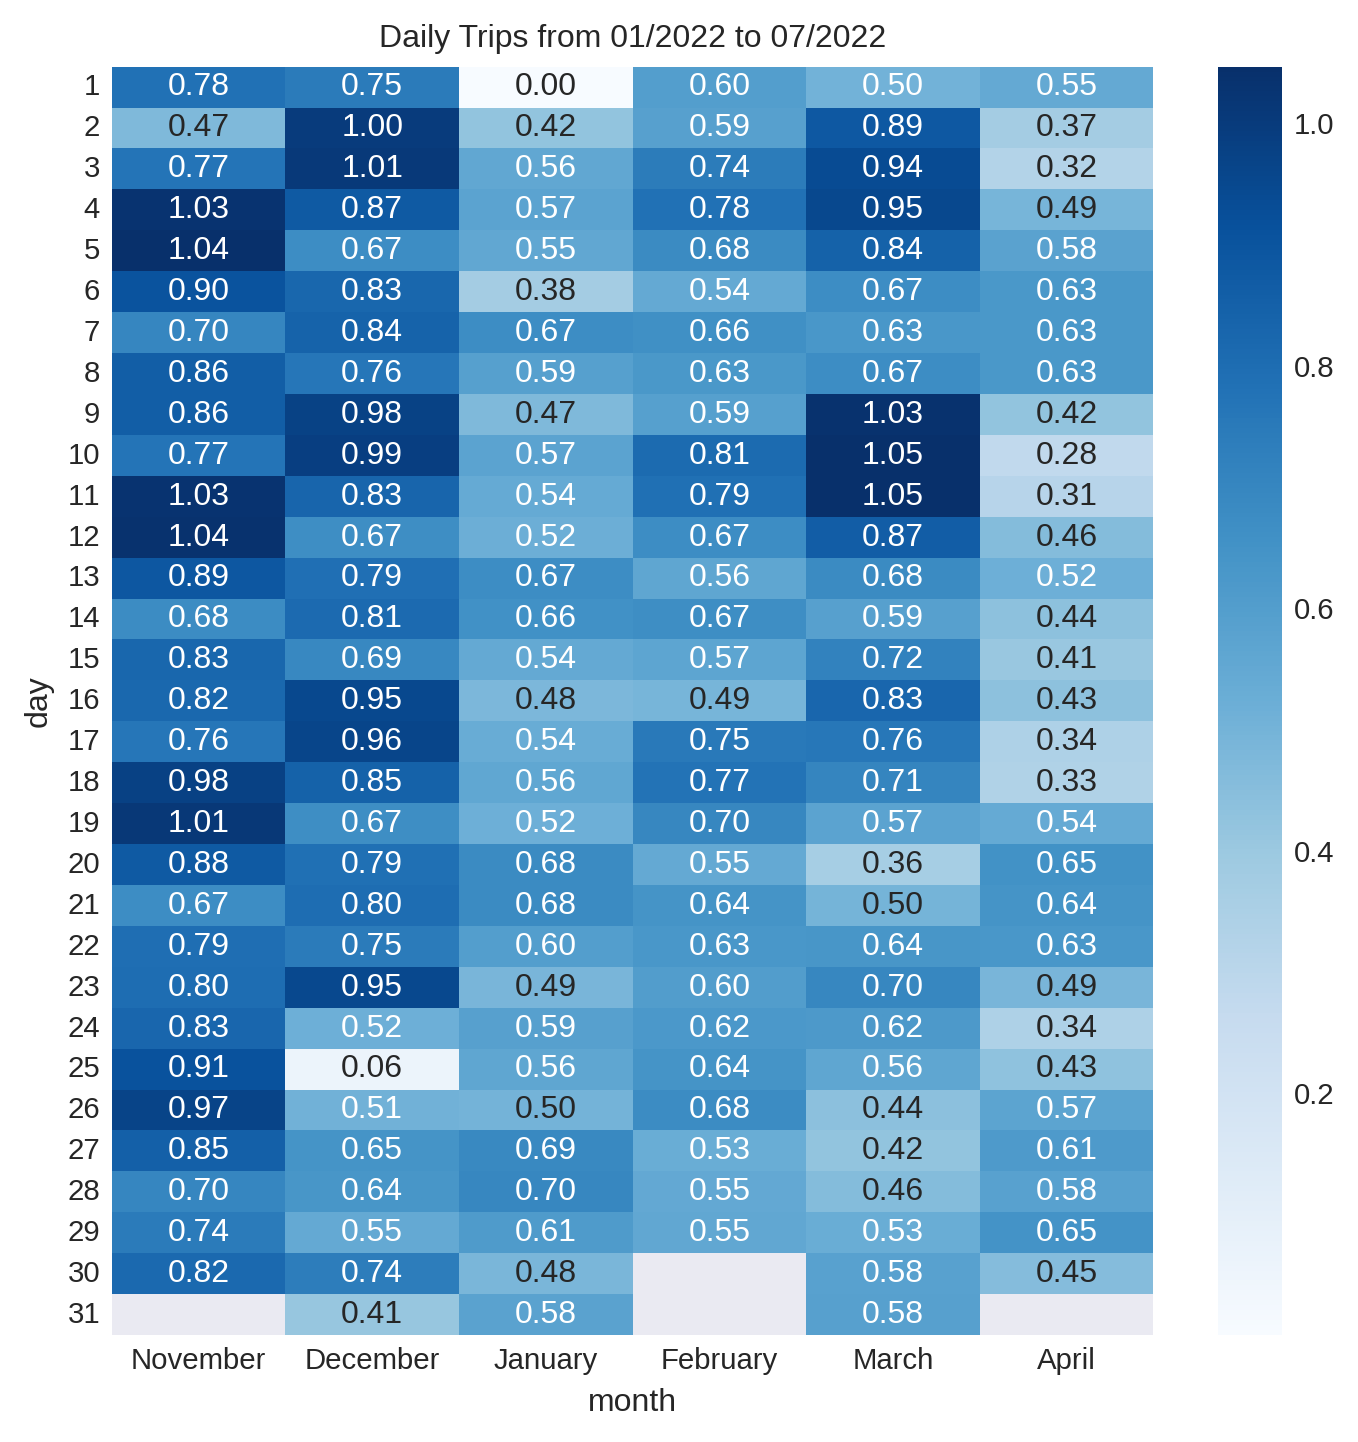

In [45]:
plt.figure(figsize=(7,7), dpi=120)

daily_trips = pd.read_csv('results/outdaily-trips', skipfooter=3, delimiter="\t", names=["date", "trips"], parse_dates=True, index_col="date")

# daily_trips.info()
# df.loc["2020"]

# df.loc[df['trips'].idxmin()]
# df['2020-03-01':'2020-04-30'].plot(title="Daily Trips 01/01/2020 - 31/03/2020", ylabel="number of trips", figsize=(12,6))

data = daily_trips['2012-01':'2022-07']\
        .assign(day=lambda x: x.index.day)\
        .assign(month=lambda x: x.index.month_name())\

data["month"] = data["month"].astype(pd.api.types.CategoricalDtype(categories=["November", "December", "January", "February", "March", "April"]))
# figure size in inches
rcParams['figure.figsize'] = 8,10

ax = sns.heatmap(data=data.pivot_table(index='day', columns='month', values='trips') / 1e6, cmap="Blues", annot=True, fmt='.2f')
_ = ax.set_yticklabels(range(1,32), rotation=0)
_ = ax.set_title("Daily Trips from 01/2022 to 07/2022")

Test con 7GB

<AxesSubplot:xlabel='Reducers', ylabel='Segundos'>

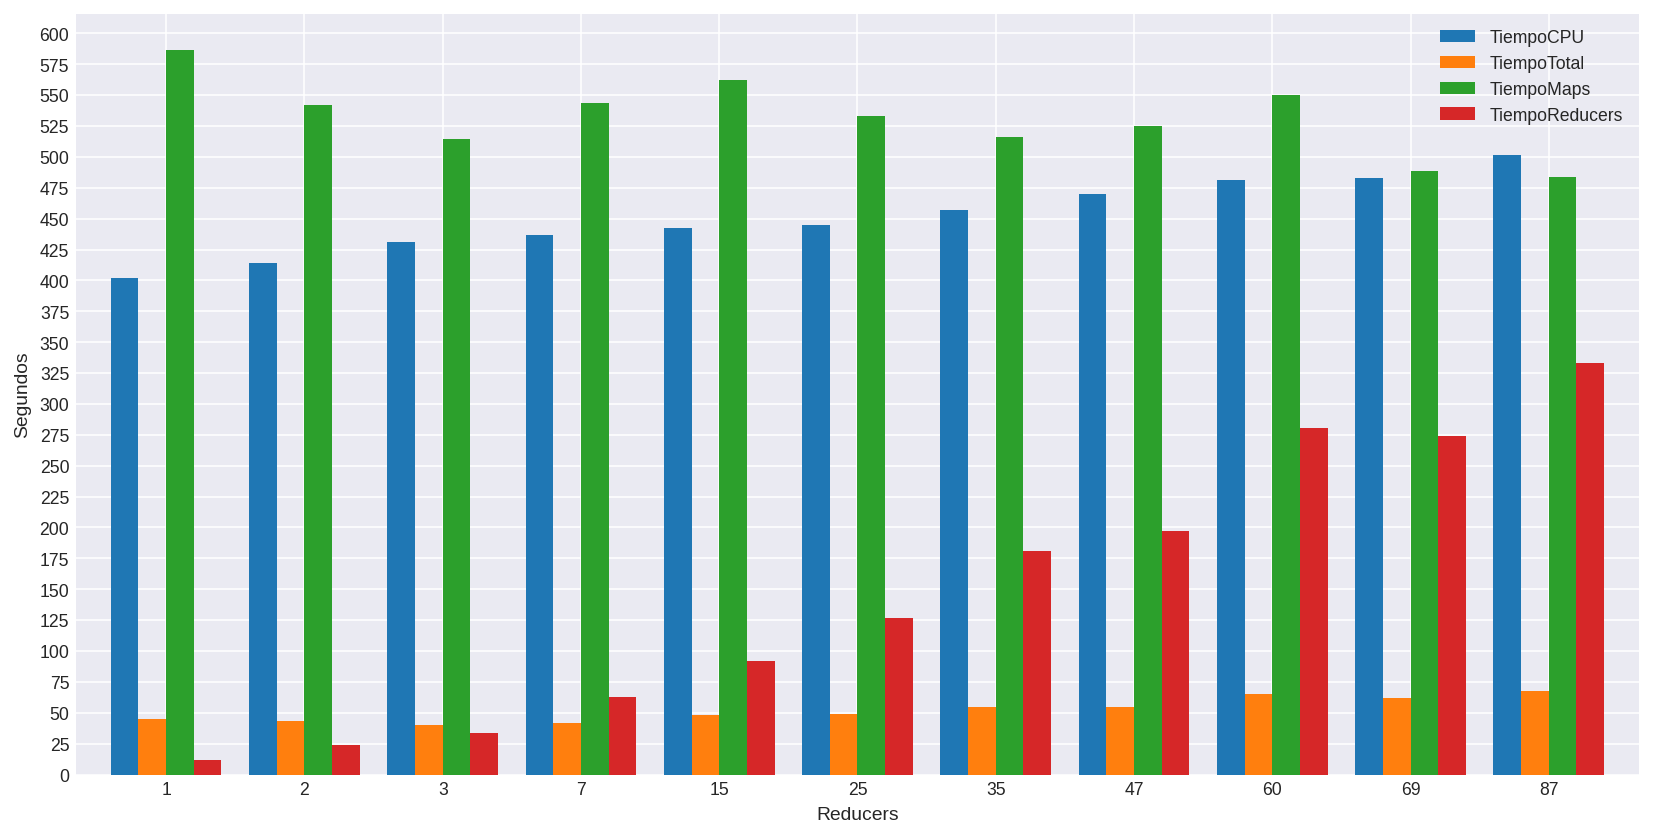

In [46]:
df = pd.read_csv('results/Tabla7GB.txt', delimiter="\t", names=["Reducers","TiempoCPU","TiempoTotal","TiempoMaps","TiempoReducers"], index_col="Reducers")
x = range(0,625,25)
rang = []
for n in x:
  rang.append(n)

df.plot(ylabel="Segundos",kind="bar", figsize=(14,7), grid=True, yticks=rang, rot=0,width=0.8)

Test con 70GB

<AxesSubplot:xlabel='Reducers', ylabel='Segundos'>

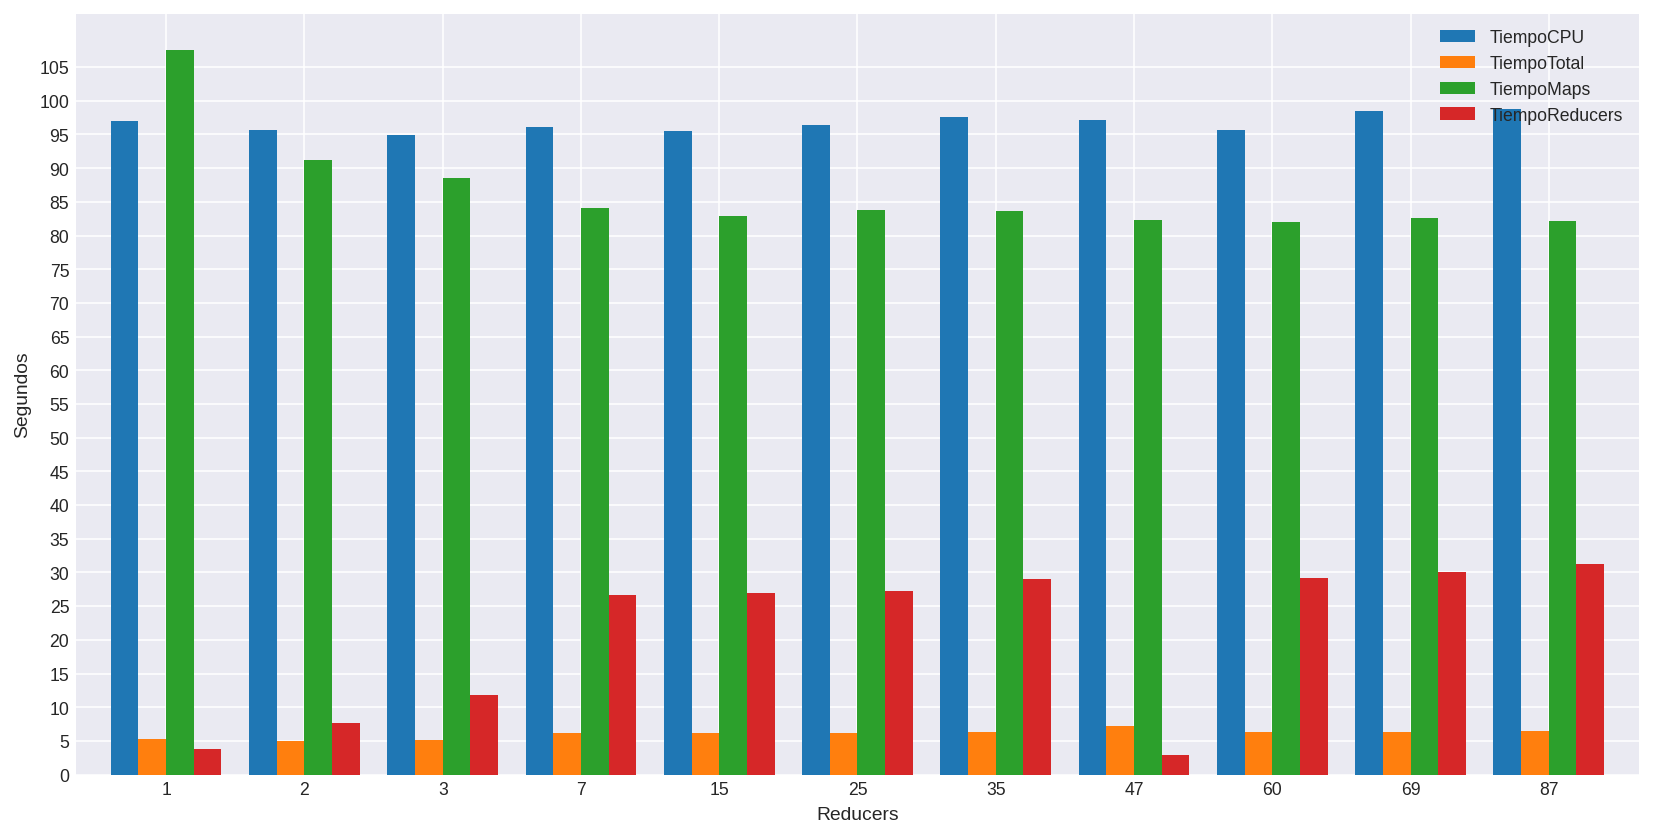

In [47]:
df = pd.read_csv('results/Tabla70GB.txt', delimiter="\t", names=["Reducers","TiempoCPU","TiempoTotal","TiempoMaps","TiempoReducers"], index_col="Reducers")
x = range(0,110,5)
rang = []
for n in x:
  rang.append(n)

df.plot(ylabel="Segundos",kind="bar", figsize=(14,7), grid=True, yticks=rang, rot=0,width=0.8)

Overlapping

<AxesSubplot:xlabel='Porcentaje', ylabel='Minutos'>

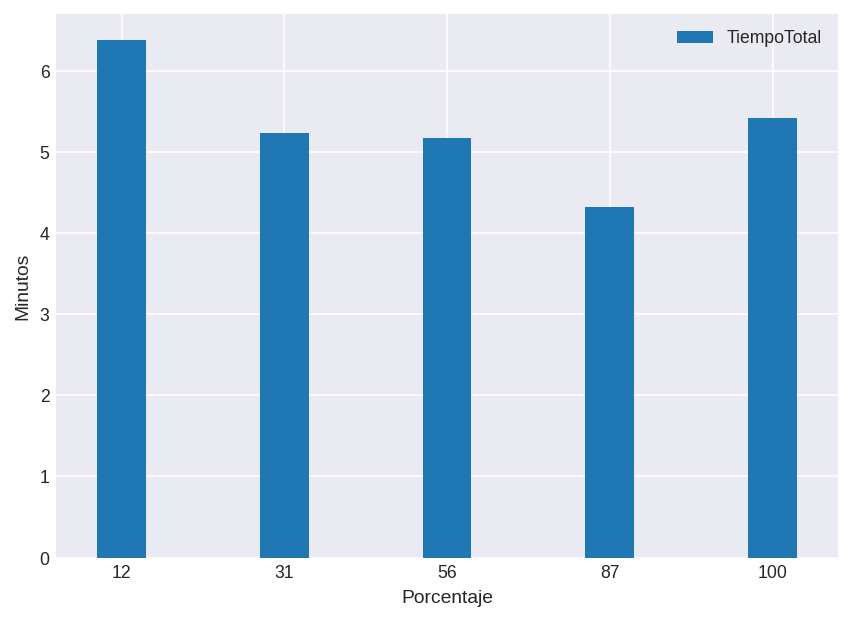

In [48]:
df = pd.read_csv('results/TablaOverlapping.txt', delimiter="\t", names=["Porcentaje","TiempoTotal"], index_col="Porcentaje")

df.plot(ylabel="Minutos",kind="bar", figsize=(7,5), grid=True, rot=0,width=0.3)